# Introduction to Machine Learning - Week 4, P.M. Kuria

## 1. Defining the Question

### a) Specifying the Data Analysis Question

 The task is to predict whether a potential promotee at a checkpoint will be promoted or not after the evaluation process.

### b) Understanding the Context

HR analytics is revolutionising the way human resources departments operate, leading to higher efficiency and better results overall. Human resources have been using analytics for years. However, the collection, processing, and analysis of data have been largely manual, and given the nature of human resources dynamics and HR KPIs, the approach has been constraining HR. Therefore, it is surprising that HR departments woke up to the utility of machine learning so late in the game.

Problem Statement

Your client is a large Multinational Corporation, and they have nine broad verticals across the organization. One of the problems your client faces is identifying the right people for promotion (only for the manager position and below) and preparing them in time.
Currently the process, they are following is:

● They first identify a set of employees based on recommendations/ past performance.

● Selected employees go through the separate training and evaluation program for each vertical.

● These programs are based on the required skill of each vertical. At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., the employee gets a promotion.
For the process mentioned above, the final promotions are only announced after the evaluation, and this leads to a delay in transition to their new roles. Hence, the company
needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle.

### c) Recording the Experimental Design


* Exploratory analysis from the data, create some visualization to describe the data
* Describe the pre-processing step, how to extract and create new features, also the reason behind them
* Split the data into training and testing with optional portion
* Build the models with matching hyperparameter tune, choose the best model, also the reason behind that
* Test the model with data test

##Load Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
from IPython.display import Image
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn import over_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from scipy.stats import uniform
import pickle
import xgboost as xgb

sns.set(rc={'figure.figsize':(16,8)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Load and Describe Data

In this project, we create our dataset into 3 different datasets:
1. `data` as the original data, used for exploratory data analysis
2. `data_clean` as the cleaned data form missing value and duplicated, used for data cleaning until feature engineering & encoding
3. `df_pre` as the final dataset used for modeling. This dataset already processed with log/norm


## Load Data

In [ ]:
data = pd.read_csv('hrdataset.csv')

#see the amount of data in the dataset
print('there are ' + str(len(data)) + ' rows of data in the dataset')
print("Total Feature", data.shape[1])
data.head()

there are 54808 rows of data in the dataset
Total Feature 14


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
#see the amount of data on each target
data['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [ ]:
print('1. The percentage of employees who have not received a promotion are ' + str(round((50140/54808)*100,2)) + '%')
print('2. The percentage of employees who get promoted are ' + str(round((4668/54808)*100,2)) + '%')

1. The percentage of employees who have not received a promotion are 91.48%
2. The percentage of employees who get promoted are 8.52%


## Describe Data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


**Conclusion**</br>
* Dataframe have 14 columns
* Dataframe have 54808 rows
* Total categorical columns are 5 columns
* Total numerical columns are 9 columns
* There are 2 columns that have a missing value (`education` and `previous_year_rating`)
* `is_promoted` column is the target for this dataset

# Data Understanding: Exploratory Data Analysis (EDA)

## Statistical Summary

### Separation of Categorical & Numerical Data

In [ ]:
# assign the categorical data into cats object
cats = ['department','region','education','gender','recruitment_channel']

# assign the numerical data into nums object
nums = ['employee_id','no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?',
        'avg_training_score','is_promoted']

### Statistical Numerical Data

In [ ]:
data[nums].describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


**Conclusion from Statistical Numerical Data**<br>

* The distribution of data for feature `no_of_trainings`, `age`, `length_of_service`, `avg_training_score` looks normal *(mean & median are close enough)*

### Statistical Categorical Data

In [ ]:
data[cats].describe()

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


**Categorical Data Conclusion**</br>
* Data majority in `gender` is male with frequency 38496
* Data majority in `department` is Sales & Marketing with frequency 16840
* Data majority in `education` is Bachelor's with frequency 36669
* Data majority in `region` is region_2 with frequency 12343
* Data majority in `recruitment_channel` is other with frequency 30446

#### Check Missing Value
<a id = 'distribution_of_missing_value'></a>
`education`
`previous_year_rating`
`employee_id`

In [ ]:
# assign features with missing value into data_missing object
data_missing = data.isnull().sum().reset_index()
data_missing.columns = ['feature','missing_value']
data_missing = data_missing[data_missing['missing_value'] > 0].reset_index(drop=True)
data_missing['percentage'] = (data_missing['missing_value']/len(data))*100
data_missing

,feature,missing_value,percentage
0,education,2409,4.395344
1,previous_year_rating,4124,7.524449


Text(0.125, 0.55, '\nThere are 2 features with missing value, 1 for numerical & 1 for non-numerical (categorical data)\n- previous_year_rating as numerical data has 7.52% (4124 rows) missing value\n- education as non-numerical data has 4.40% (2409 rows) missing value\n\nCompared to the dataset, this missing value is not too big\n')

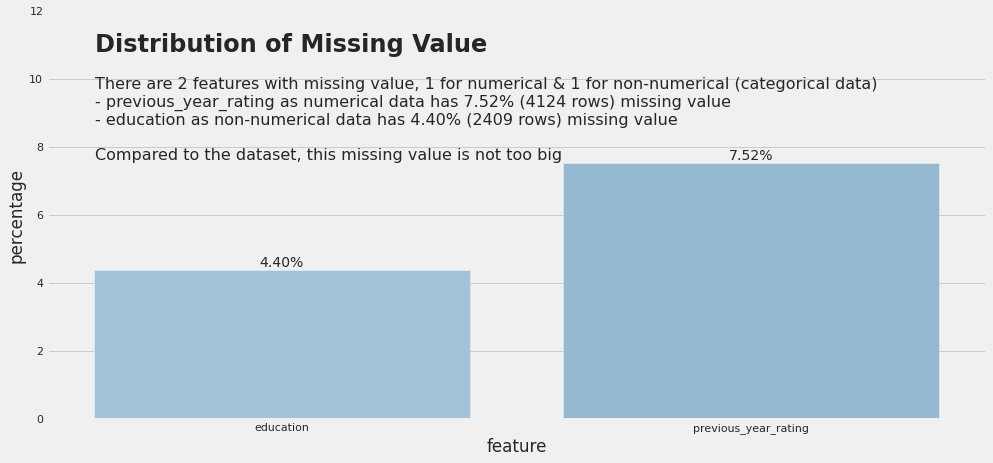

In [ ]:
fig, ax = plt.subplots(figsize = (15,7))

mvalue_plot = sns.barplot(x='feature', y='percentage', data=data_missing,
           palette = sns.color_palette('Blues_d', n_colors = 13, desat = 1))

ax.set_ylim(0,12)

for p in mvalue_plot.patches:
    height = p.get_height()
    mvalue_plot.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.1,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center')

title = '''Distribution of Missing Value'''
fig.text(x=0.125, y=0.8, s = title, fontsize = 24, weight = 'bold')

text = '''
There are 2 features with missing value, 1 for numerical & 1 for non-numerical (categorical data)
- previous_year_rating as numerical data has 7.52% (4124 rows) missing value
- education as non-numerical data has 4.40% (2409 rows) missing value

Compared to the dataset, this missing value is not too big
'''
fig.text(x=0.125, y=0.55, s = text, fontsize=16)

#plt.savefig('fig/Distribution of Missing Value.png')


**There are 2 features with missing value, 1 numeric & 1 non-numeric. the `education` feature with non-numeric data types has 4.40% missing value and the `previous_year_rating` feature with numeric data types has 7.52% missing value. When compared with the total row data, the number of missing values is relatively small.**

#### Check Cardinality or Unique Value from Categocial Data
<a id = 'unique_value' ></a>

In [ ]:
# check the cardinality or unique value from categorical data 
# and assign thgem into data_cat_unique object
display(data.select_dtypes(include=['object']).columns)
print(data.select_dtypes(include=object).shape)
data_cat = data.select_dtypes(include=['object'])
data_cat.head(3)

Index(['department', 'region', 'education', 'gender', 'recruitment_channel'], dtype='object')

(54808, 5)


,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing


In [ ]:
data_cat_unique = data_cat.nunique().reset_index()
data_cat_unique.columns = ['feature', 'unique value']
data_cat_unique = data_cat_unique.sort_values('unique value', ascending=False).reset_index(drop=True)
data_cat_unique

,feature,unique value
0,region,34
1,department,9
2,education,3
3,recruitment_channel,3
4,gender,2


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

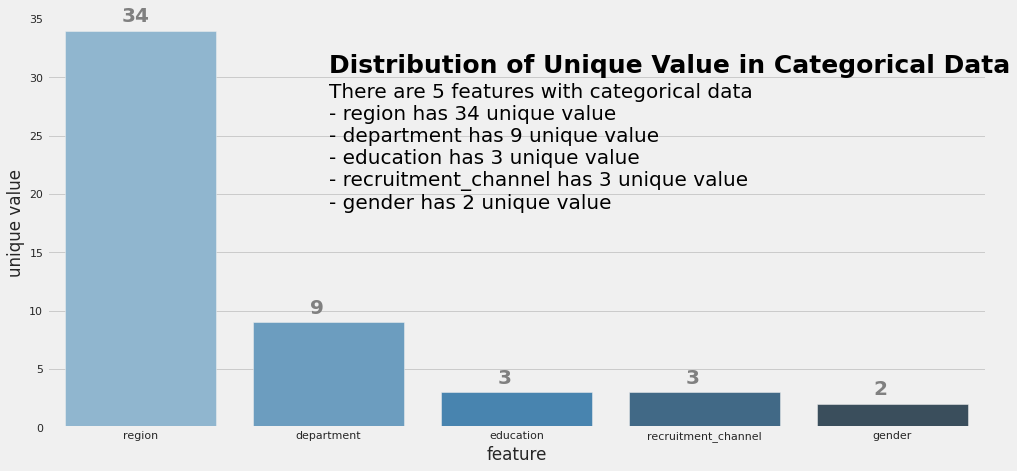

In [ ]:
#melihat distribusi unique value dari data categorical
fig, ax = plt.subplots(figsize=(15,7))

g = sns.barplot(x = 'feature',y='unique value',data=data_cat_unique,ax=ax, 
               palette=sns.color_palette("Blues_d", n_colors=5, desat=1))

x = np.arange(len(data_cat_unique['feature']))
y = data_cat_unique['unique value']

for i, v in enumerate(y):
    ax.text(x[i]- 0.1, v+0.75, str(v), fontsize = 20, color='gray', fontweight='bold')
    
title = '''
Distribution of Unique Value in Categorical Data
'''
ax.text(1,28,title,horizontalalignment='left',color='black',fontsize=25,fontweight='bold')
    

text = '''
There are 5 features with categorical data
- region has 34 unique value
- department has 9 unique value
- education has 3 unique value
- recruitment_channel has 3 unique value
- gender has 2 unique value

'''
plt.text(1,23,text,horizontalalignment='left',color='black',fontsize=20,fontweight='normal',va='center')
    
ax.set_ylim(0,35)

ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.tight_layout

#plt.savefig('fig/Insight Awal ke-9.png')

#### Check Dulicated Data

In [ ]:
data.duplicated().sum()

0

**In the raw data, there are no duplicate values**

**Early Brief**<br>
* Dataset has 14 features and 54808 rows
* 5 features are in categorical data **(inlude 1 feature as target, `is_promoted`)**
* 9 features are in numerical data
* There are 2 features with missing value: 
    - 2409 rows in `education`
    - 4124 rows in `previous_year_rating`
* There are no duplicated data, at least before data preparation 

## Graphical Approach

### Univariate Analysis
*Do data analysis for each feature separately, look the distrbution of data in details*

#### Numerical Data

In [ ]:
#assign numerical data into dat_num object
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(data.select_dtypes(include=numerics).columns)
print(data.select_dtypes(include=numerics).shape)
data_num = data.select_dtypes(include=numerics)
data_num.head(3)

Index(['employee_id', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

(54808, 9)


,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,1,35,5.0,8,1,0,49,0
1,65141,1,30,5.0,4,0,0,60,0
2,7513,1,34,3.0,7,0,0,50,0


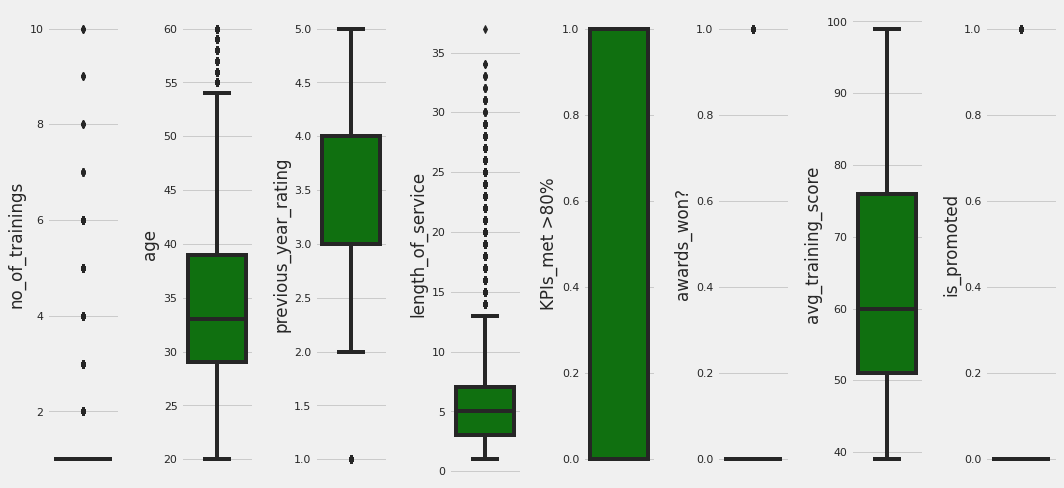

In [ ]:
# look at the distribution of data with boxplot
features = ['no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?','avg_training_score','is_promoted']
plt.figure(figsize=(15, 7))
for i in range(0, len(features)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y=data[features[i]],color='green',orient='v')
    plt.tight_layout()

##### Distribution of Promoted Employees based on `age`
<a id = 'promoted_by_age' ></a>

In [ ]:
title = '''
Distribution of Promoted Employees based on age
'''
fig = px.histogram(data, x="age", title = title,
                   color = "is_promoted", 
                   labels= {"age":"Age","is_promoted": "Promoted"},
                   nbins=35,
                   color_discrete_sequence=px.colors.qualitative.Pastel1
                  )

fig.update_layout(yaxis_title=" ")
fig.update_layout(
    autosize=False,
    width=900,
    height=650)
fig.show()

print("The average age of the employees is " + str(round(np.mean(data.age),0)))
print("The median age of the employees is " + str(np.median(data.age)))

The average age of the employees is 35.0
The median age of the employees is 33.0


##### Probability to Get Promotion based on `KPIs_met >80%`
<a id = 'promoted_by_kpi'></a>

In [ ]:
prob_kpi = data.groupby(['KPIs_met >80%','is_promoted'])['employee_id'].count().reset_index()
kpi = prob_kpi.pivot_table(index='KPIs_met >80%', columns='is_promoted', 
                       values='employee_id').reset_index()
kpi.columns = ['kpi', 'not_promoted', 'promoted']
kpi['total'] = kpi['not_promoted']+kpi['promoted']
kpi['probability'] = round((kpi['promoted']/kpi['total'])*100,2)
kpi = kpi.sort_values(['probability'], ascending=False)
kpi

,kpi,not_promoted,promoted,total,probability
1,1,16029,3262,19291,16.91
0,0,34111,1406,35517,3.96


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

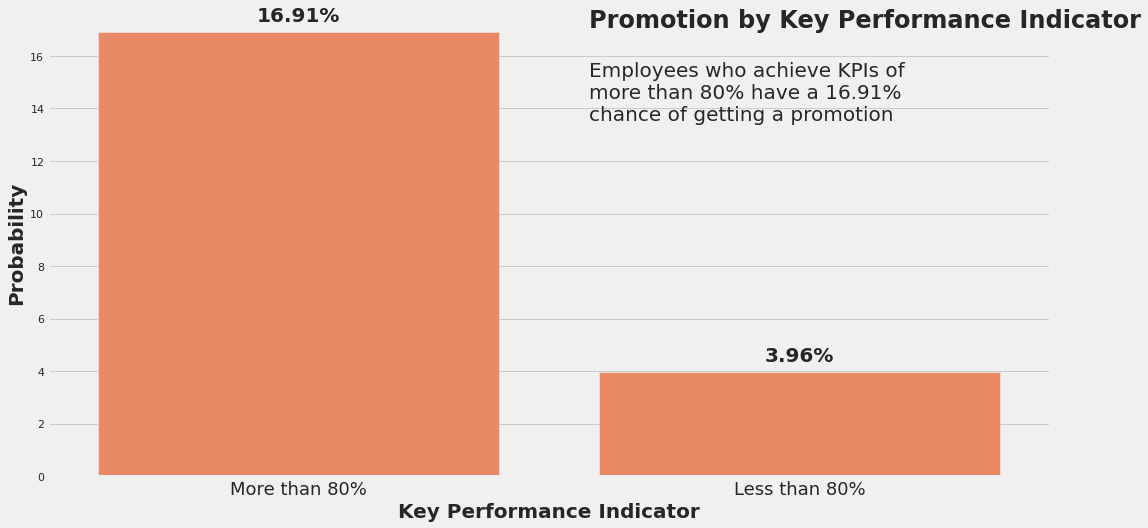

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan Kpi
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='kpi', y='probability', 
                data=kpi,ax=ax1,color='coral',
               order=kpi.sort_values('probability',ascending = False).kpi)

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.4,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=20,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Key Performance Indicator'''
fig.text(x=0.55, y=0.85, s=title, fontsize=24, weight='bold')

#add description
text = '''
Employees who achieve KPIs of 
more than 80% have a 16.91% 
chance of getting a promotion
'''
fig.text(x=0.55, y=0.65, s=text, fontsize=20)

#set y axis limit 
#plt.ylim(0, 20)

# add label
plt.xlabel('Key Performance Indicator', fontsize = 20, weight='bold')
plt.ylabel('Probability', fontsize = 20, weight='bold')
g.set_xticklabels(['More than 80%', 'Less than 80%'], fontsize = 18)

plt.tight_layout
#plt.savefig('fig/KPI Promoted Probability.png');

##### Probability to Get Promotion based on `previous_year_rating`
<a id = 'previous_year_rating' ></a>

In [ ]:
rating_probs = data.groupby(['previous_year_rating','is_promoted']).agg({
    'department': ['count']
}).reset_index()

rating_probs.columns = ['previous_year_rating', 'is_promoted', "employees"]

rating_probs = pd.pivot_table(rating_probs,
                              index = 'previous_year_rating',
                              columns = 'is_promoted',
                              values = "employees"
                             ).reset_index()

rating_probs.columns = ['previous_year_rating', 'not_promoted', 'promoted']
rating_probs['total_employees'] = rating_probs['not_promoted'] + rating_probs['promoted']
rating_probs['promotion_probs'] = (rating_probs['promoted']/(rating_probs['not_promoted']+rating_probs['promoted']))*100
rating_probs = rating_probs.sort_values('promotion_probs', ascending=False).reset_index(drop=True)
rating_probs

,previous_year_rating,not_promoted,promoted,total_employees,promotion_probs
0,5.0,9820,1921,11741,16.361468
1,4.0,9093,784,9877,7.937633
2,3.0,17263,1355,18618,7.277903
3,2.0,4044,181,4225,4.284024
4,1.0,6135,88,6223,1.414109


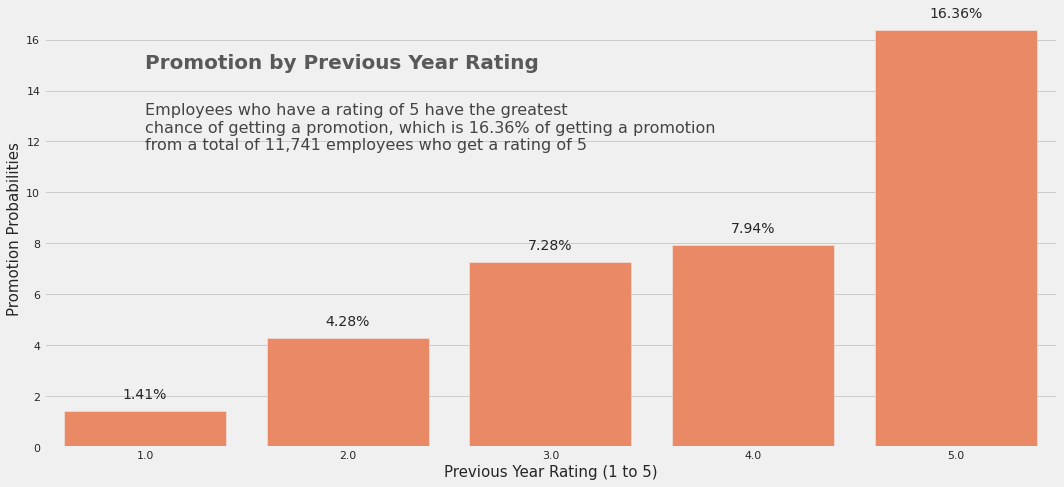

In [ ]:
#melihat peluang yang dipromosikan berdasarkan previous_year_rating
fig, ax = plt.subplots(figsize=(15,7))
#g = plt.bar(x='previous_year_rating', height='promotion_probs',data=rating_probs)

g = sns.barplot(x='previous_year_rating', y='promotion_probs', data=rating_probs,
                order=rating_probs.sort_values('promotion_probs')['previous_year_rating'],
                color = 'coral')

for p in g.patches:
    height = p.get_height()
    plt.text(x = p.get_x() + (p.get_width()/2),
           y = height + 0.5,
           s = str('{:.2f}'.format(height)) + '%',
           ha = 'center'
          )

title = '''
Promotion by Previous Year Rating
'''

text = '''
Employees who have a rating of 5 have the greatest 
chance of getting a promotion, which is 16.36% of getting a promotion
from a total of 11,741 employees who get a rating of 5
'''

#plt.yticks([]) # Hide the y-axis with empty list
plt.xlabel('Previous Year Rating (1 to 5)', fontsize = 15) # Add the x-label
plt.ylabel('Promotion Probabilities', fontsize = 15) # Add the y-label

plt.text(x = 0, y = 14, s=title,
        fontsize = 20, weight = 'bold', alpha = .75)
plt.text(x = 0, y = 11, s=text,
        fontsize = 16, alpha = .85)
plt.tight_layout();

#plt.savefig('fig/Promotion by Rating.png')

##### Probability to Get Promotion based on `awards_won?`
<a id = 'awards_won?' ></a>

In [ ]:
data_awards = pd.pivot_table(data,
                    index = ['awards_won?'],
                    columns = ['is_promoted'],
                    aggfunc = {'is_promoted' : ['count']}).reset_index()
data_awards.columns = ['awards_won', 'not_promoted', 'promoted']
data_awards['total'] = data_awards['not_promoted']+data_awards['promoted']
data_awards['probability'] = round((data_awards['promoted']/data_awards['total'])*100,2)
data_awards = data_awards.sort_values(['probability'], ascending=False)
data_awards

,awards_won,not_promoted,promoted,total,probability
1,1,711,559,1270,44.02
0,0,49429,4109,53538,7.67


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

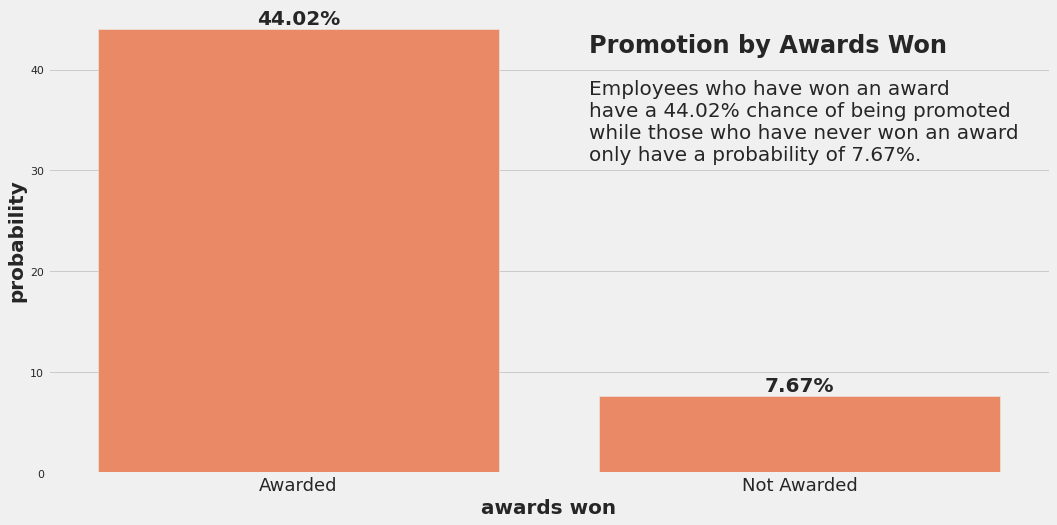

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan yang mendapatkan awards
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='awards_won', y='probability', 
                data=data_awards,ax=ax1,color='coral',
               order=data_awards.sort_values('probability',ascending = False).awards_won)

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.4,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=20,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Awards Won'''
fig.text(x=0.55, y=0.8, s=title, fontsize=24, weight='bold')

#add description
text = '''
Employees who have won an award 
have a 44.02% chance of being promoted
while those who have never won an award
only have a probability of 7.67%.
'''
fig.text(x=0.55, y=0.575, s=text, fontsize=20)

#set y axis limit 
#plt.ylim(0, 20)

# add label
plt.xlabel('awards won', fontsize = 20, weight='bold')
plt.ylabel('probability', fontsize = 20, weight='bold')
g.set_xticklabels(['Awarded', 'Not Awarded'], fontsize = 18)

plt.tight_layout
#plt.savefig('fig/Promotion by Awards.png');

##### Distribution & Probability of Promoted Employees based on `length_of_service`
<a id = 'length_of_service' ></a>

In [ ]:
prob_los = data.groupby(['length_of_service','is_promoted'])['employee_id'].count().reset_index()
los = prob_los.pivot_table(index='length_of_service', columns='is_promoted', 
                       values='employee_id').reset_index()
los.columns = ['length_of_service', 'not_promoted', 'promoted']
los['promoted'] = los['promoted'].fillna(0)
los['total'] = los['not_promoted']+los['promoted']
los['probability'] = round((los['promoted']/los['total'])*100,2)
los = los.sort_values(['probability'], ascending=False)
los.head()

,length_of_service,not_promoted,promoted,total,probability
33,34,3.0,1.0,4.0,25.00
31,32,8.0,2.0,10.0,20.00
22,23,58.0,7.0,65.0,10.77
10,11,820.0,96.0,916.0,10.48
28,29,27.0,3.0,30.0,10.00


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

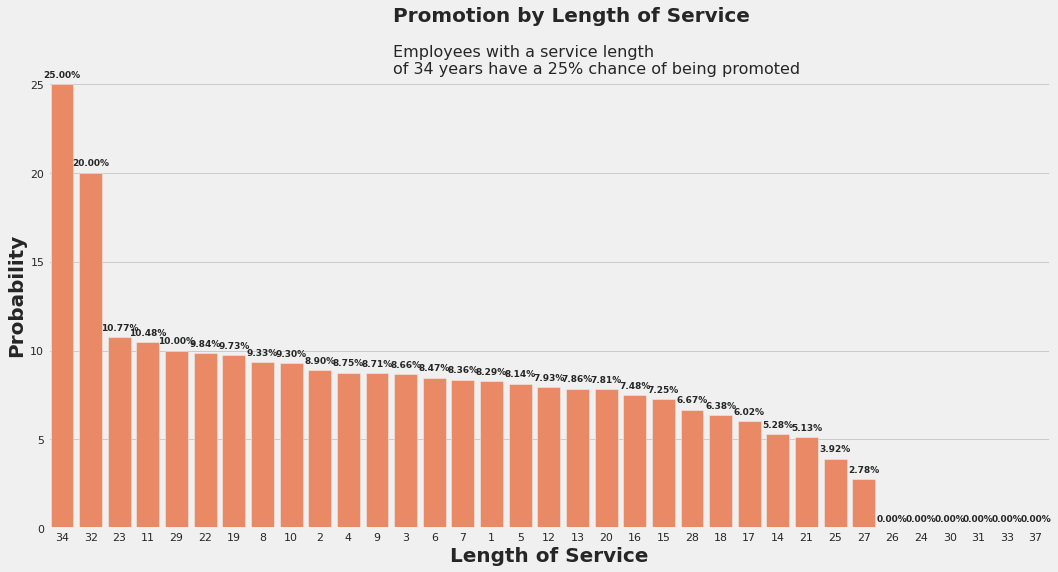

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan Kpi
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='length_of_service', y='probability', 
                data=los,ax=ax1,color='coral',
               order=los.sort_values('probability',ascending = False).length_of_service)

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.4,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=9,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Length of Service'''
fig.text(x=0.38, y=0.95, s=title, fontsize=20, weight='bold')

#add description
text = '''
Employees with a service length
of 34 years have a 25% chance of being promoted
'''
fig.text(x=0.38, y=0.83, s=text, fontsize=16)

#set y axis limit 
#plt.ylim(0, 20)

# add label
plt.xlabel('Length of Service', fontsize = 20, weight='bold')
plt.ylabel('Probability', fontsize = 20, weight='bold')

plt.tight_layout
#plt.savefig('fig/Promotion by Length of Service.png');

##### Probability to Get Promotion based on `no_of_trainings`
<a id = 'no_of_trainings' ></a>

In [ ]:
nof_probs = data.groupby(['no_of_trainings', 'is_promoted']).agg({
    'department': ['count']
}).reset_index()

nof_probs.columns = ['no_of_trainings', 'is_promoted','employees']

nof_probs = pd.pivot_table(nof_probs,
                             index = 'no_of_trainings',
                             columns = 'is_promoted',
                             values = 'employees').reset_index()

nof_probs.columns = ['no_of_trainings','not_promoted','promoted']
nof_probs['total_employees'] = nof_probs['not_promoted'] + nof_probs['promoted']
nof_probs['promotion_probs'] = (nof_probs['promoted']/(nof_probs['not_promoted']+nof_probs['promoted']))*100
nof_probs = nof_probs.sort_values('promotion_probs', ascending=False).reset_index(drop=True)
nof_probs

,no_of_trainings,not_promoted,promoted,total_employees,promotion_probs
0,1,40468.0,3910.0,44378.0,8.810672
1,2,7382.0,605.0,7987.0,7.574809
2,3,1654.0,122.0,1776.0,6.869369
3,4,442.0,26.0,468.0,5.555556
4,6,42.0,2.0,44.0,4.545455
5,5,125.0,3.0,128.0,2.343750
6,7,12.0,NaN,NaN,NaN
7,8,5.0,NaN,NaN,NaN
8,9,5.0,NaN,NaN,NaN
9,10,5.0,NaN,NaN,NaN


In [ ]:
# due to there are no value in some rows in promoted column, just drop it
nof_probs = nof_probs.drop(nof_probs[nof_probs['no_of_trainings']>= 7].index)
nof_probs

,no_of_trainings,not_promoted,promoted,total_employees,promotion_probs
0,1,40468.0,3910.0,44378.0,8.810672
1,2,7382.0,605.0,7987.0,7.574809
2,3,1654.0,122.0,1776.0,6.869369
3,4,442.0,26.0,468.0,5.555556
4,6,42.0,2.0,44.0,4.545455
5,5,125.0,3.0,128.0,2.343750


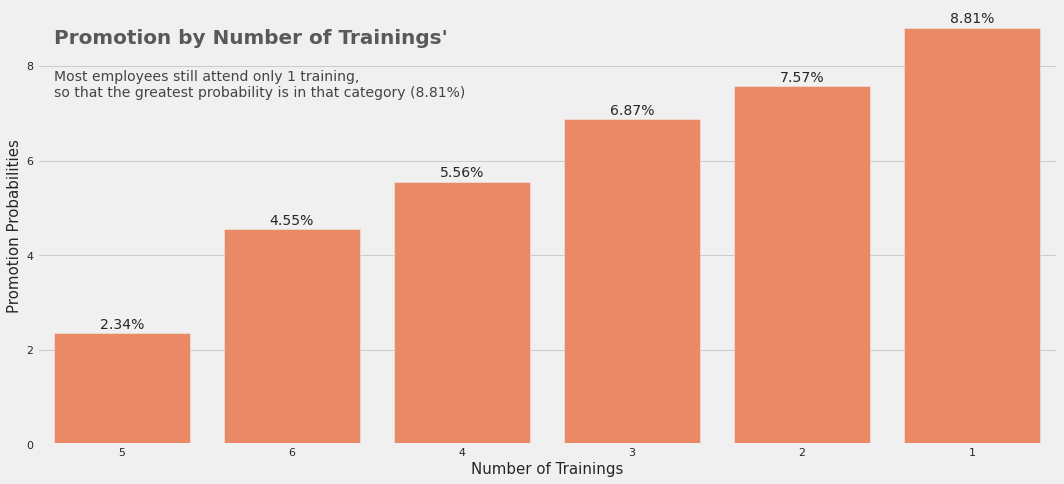

In [ ]:
#melihat peluang yang dipromosikan berdasarkan no_of_trainings
fig, ax = plt.subplots(figsize=(15,7))

g = sns.barplot(x='no_of_trainings', y='promotion_probs', data=nof_probs,
                order=nof_probs.sort_values('promotion_probs')['no_of_trainings'],
                color='coral')

for p in g.patches:
    height = p.get_height()
    plt.text(x = p.get_x() + (p.get_width()/2),
           y = height + 0.1,
           s = str('{:.2f}'.format(height)) + '%',
           ha = 'center'
          )

title = '''
Promotion by Number of Trainings'
'''

text = '''
Most employees still attend only 1 training, 
so that the greatest probability is in that category (8.81%)
'''

#plt.yticks([]) # Hide the y-axis with empty list
plt.xlabel('Number of Trainings', fontsize = 15) # Add the x-label
plt.ylabel('Promotion Probabilities', fontsize = 15) # Add the y-label

plt.text(x = -0.4, y = 8, s=title,
        fontsize = 20, weight = 'bold', alpha = .75)
plt.text(x = -0.4, y = 7, s=text,
        fontsize = 14, alpha = .85)
plt.tight_layout();

#plt.savefig('fig/Promotion by no of trainings.png')

##### Distribution & Probability of Promoted Employees based on `avg_training_score`
<a id = 'avg_training_score' ></a>

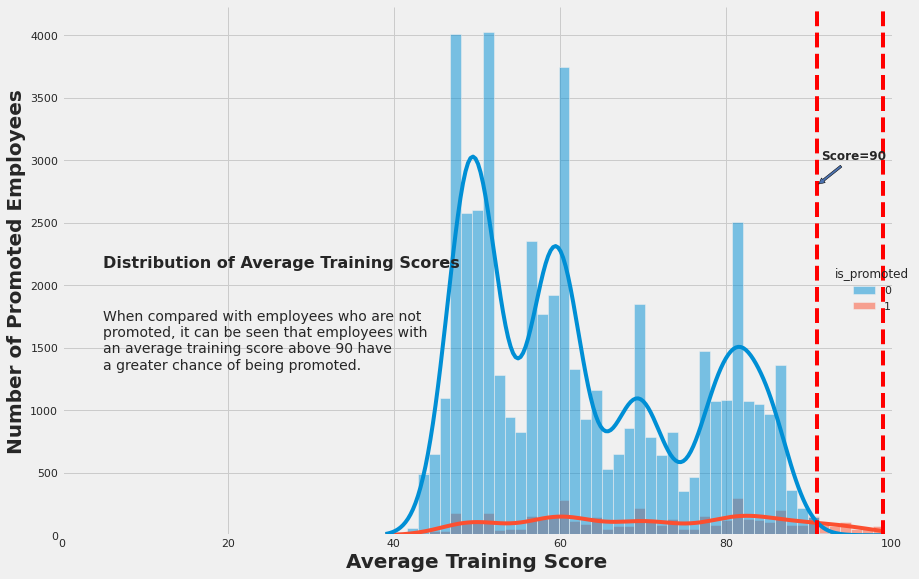

In [ ]:
g = sns.displot(data=data, x="avg_training_score", 
            hue='is_promoted', kde=True, height=8.27, 
            aspect=11.7/8.27)

title='''
Distribution of Average Training Scores
'''

plt.text(x=5, y=2000, s=title, fontsize=16, weight='bold', ha='left')

text='''
When compared with employees who are not
promoted, it can be seen that employees with
an average training score above 90 have
a greater chance of being promoted.
'''

plt.text(x=5, y=1200, s=text, fontsize=14, ha='left')

plt.xlim(0, 100)

#make red line
plt.axvline(x=91, ls = '--', color = 'red')
plt.axvline(x=99, ls = '--', color = 'red')
plt.annotate(xy=(91,2800), xytext=(86.5+5,3000+5), s='''Score=90''',
             fontsize=12, weight='bold',
            arrowprops=dict(ec='black', # color arrow
                            arrowstyle='simple', #style of arrow
                           ))
plt.xlabel('Average Training Score', fontsize = 20, weight='bold')
plt.ylabel('Number of Promoted Employees', fontsize = 20, weight='bold')
plt.tight_layout();

#plt.savefig('fig/Insight Avg Training 2.png');

In [ ]:
prob_avg = data.groupby(['avg_training_score','is_promoted'])['employee_id'].count().reset_index()
avg = prob_avg.pivot_table(index='avg_training_score', columns='is_promoted', 
                       values='employee_id').reset_index()
avg.columns = ['avg_training_score', 'not_promoted', 'promoted']
avg['not_promoted'] = avg['not_promoted'].fillna(0)
avg['promoted'] = avg['promoted'].fillna(0)
avg['total'] = avg['not_promoted']+avg['promoted']
avg['probability'] = round((avg['promoted']/avg['total'])*100,2)
avg['score90'] = np.where(avg['avg_training_score']>=90, 'high_score', 'low_score')
avg.head()

,avg_training_score,not_promoted,promoted,total,probability,score90
0,39,2.0,0.0,2.0,0.00,low_score
1,40,5.0,0.0,5.0,0.00,low_score
2,41,25.0,1.0,26.0,3.85,low_score
3,42,60.0,2.0,62.0,3.23,low_score
4,43,169.0,7.0,176.0,3.98,low_score


In [ ]:
score = avg.groupby(['score90'])['promoted','total'].sum().reset_index()
score['probability'] = round((score['promoted']/score['total'])*100,2)
score

,score90,promoted,total,probability
0,high_score,587.0,764.0,76.83
1,low_score,4081.0,54044.0,7.55


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

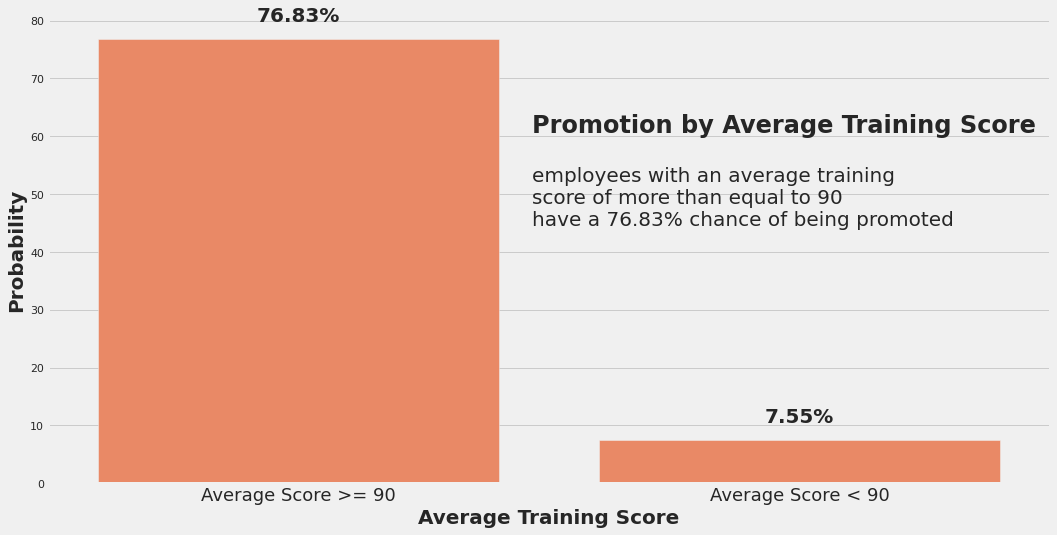

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan Kpi
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='score90', y='probability', 
                data=score,ax=ax1,color='coral',
               order=score.sort_values('probability',ascending = False).score90)

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 3,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=20,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Average Training Score'''
fig.text(x=0.50, y=0.68, s=title, fontsize=24, weight='bold')

#add description
text = '''
employees with an average training
score of more than equal to 90 
have a 76.83% chance of being promoted
'''
fig.text(x=0.50, y=0.48, s=text, fontsize=20)

#set y axis limit 
#plt.ylim(0, 100)

# add label
plt.xlabel('Average Training Score', fontsize = 20, weight='bold')
plt.ylabel('Probability', fontsize = 20, weight='bold')
g.set_xticklabels(['Average Score >= 90', 'Average Score < 90'], fontsize = 18)

plt.tight_layout
#plt.savefig('fig/Avg Score Promoted Probability.png');

#### Non - Numerical (Categorical)

In [ ]:
# assign categorical data into data_cat object
display(data.select_dtypes(include=['object']).columns)
print(data.select_dtypes(include=object).shape)
data_cat = data.select_dtypes(include=['object'])
data_cat.head(3)

Index(['department', 'region', 'education', 'gender', 'recruitment_channel'], dtype='object')

(54808, 5)


,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing


### Multivariate Analysis

#### Numerical Data
* See the correlation between features using correlation matrix

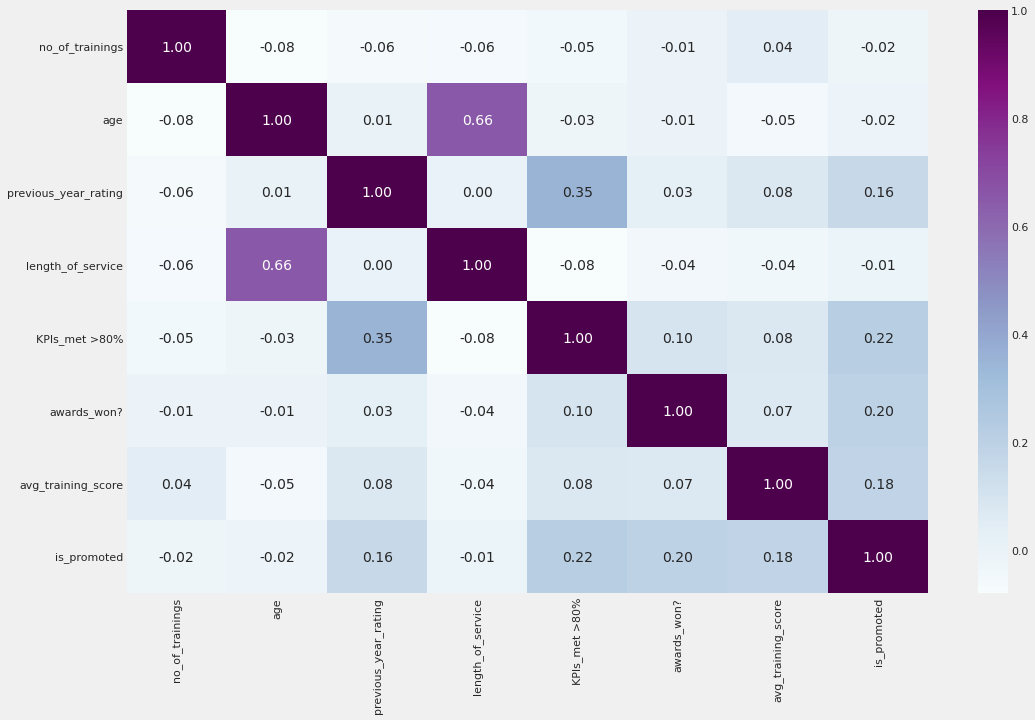

In [ ]:
#membuat matriks korelasi dari setiap data numerik
features = ['no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?','avg_training_score','is_promoted']
corr_= data[features].corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu");

#### Non Numerical Data (Categorical)

##### Probability to Get Promotion based on `region`
<a id = 'promoted_by_region' ></a>

In [ ]:
region_probs = data.groupby(['region', 'is_promoted']).agg({
    'department': ['count']
}).reset_index()

region_probs.columns = ['region', 'is_promoted','employees']

region_probs = pd.pivot_table(region_probs,
                             index = 'region',
                             columns = 'is_promoted',
                             values = 'employees').reset_index()

region_probs.columns = ['region','not_promoted','promoted']
region_probs['promotion_probs'] = (region_probs['promoted']/(region_probs['not_promoted']+region_probs['promoted']))*100
region_probs = region_probs.sort_values('promotion_probs', ascending=False).reset_index(drop=True)
region_probs.head()

,region,not_promoted,promoted,promotion_probs
0,region_4,1457,246,14.445097
1,region_17,687,109,13.693467
2,region_25,716,103,12.576313
3,region_28,1164,154,11.684370
4,region_23,1038,137,11.659574


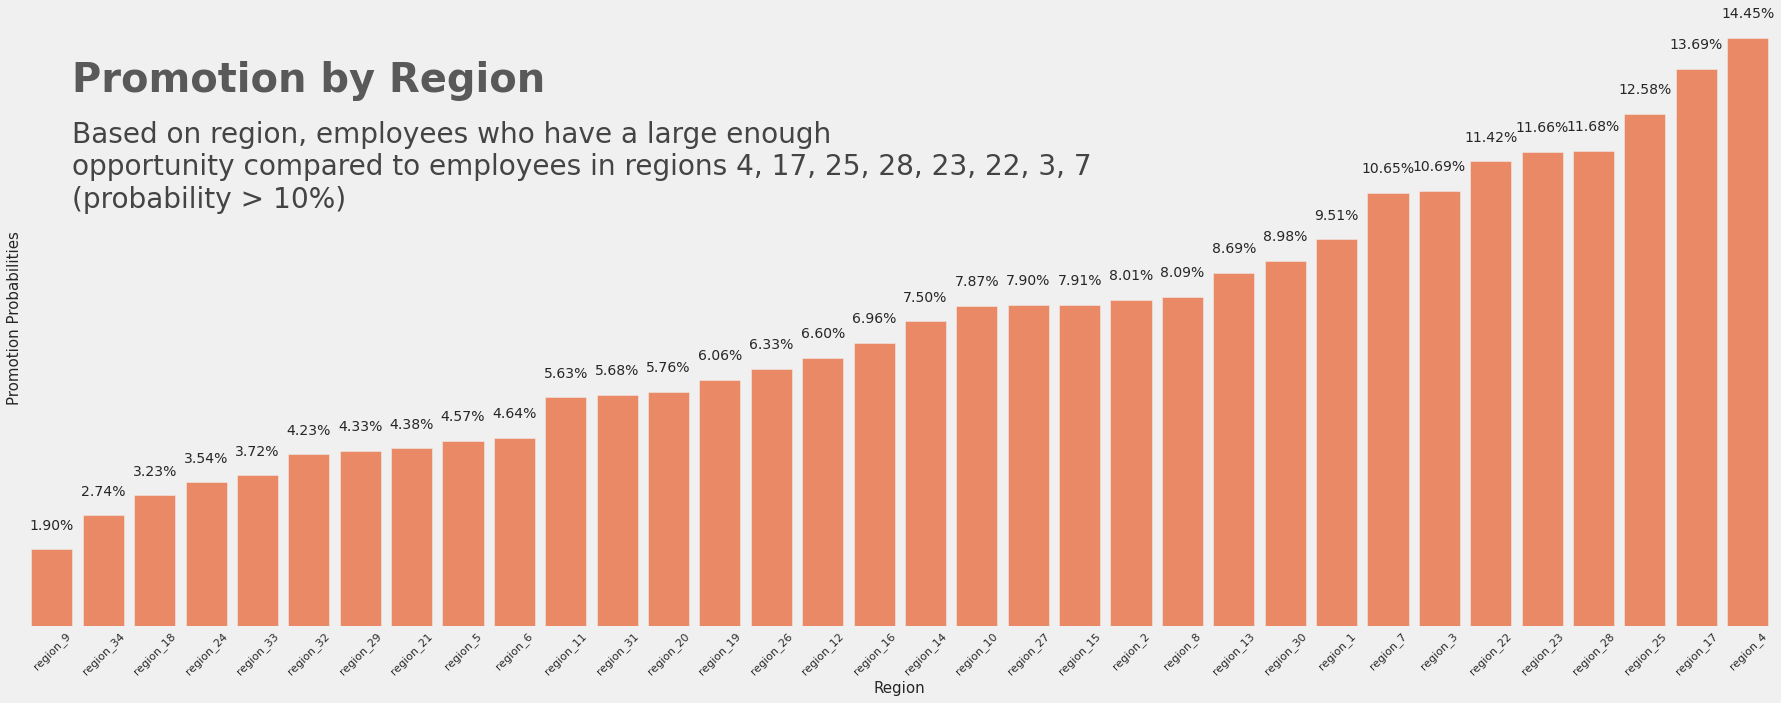

In [ ]:
#melihat peluang yang dipromosikan berdasarkan region
fig, ax = plt.subplots(figsize=(25,10))

g = sns.barplot(x='region', y='promotion_probs', data=region_probs,
                order=region_probs.sort_values('promotion_probs')['region'],
                color = 'coral')

plt.xticks(rotation=45)
for p in g.patches:
    height = p.get_height()
    plt.text(x = p.get_x() + (p.get_width()/2),
           y = height + 0.5,
           s = str('{:.2f}'.format(height)) + '%',
           ha = 'center'
          )

title = '''
Promotion by Region
'''

text = '''
Based on region, employees who have a large enough
opportunity compared to employees in regions 4, 17, 25, 28, 23, 22, 3, 7 
(probability > 10%)
'''

plt.yticks([]) # Hide the y-axis with empty list
plt.xlabel('Region', fontsize = 15) # Add the x-label
plt.ylabel('Promotion Probabilities', fontsize = 15) # Add the y-label

plt.text(x = 0.4, y = 12, s=title,
        fontsize = 40, weight = 'bold', alpha = .75)
plt.text(x = 0.4, y = 9.5, s=text,
        fontsize = 28, alpha = .85)
plt.tight_layout();

#plt.savefig('fig/Promotion by Region.png')

##### Probability to Get Promotion based on `department`
<a id = 'promoted_by_department' ></a>

In [ ]:
data_department = pd.pivot_table(data,
                    index = ['department'],
                    columns = ['is_promoted'],
                    aggfunc = {'is_promoted' : ['count']}).reset_index()
data_department.columns = ['department', 'not_promoted', 'promoted']
data_department['total'] = data_department['not_promoted']+data_department['promoted']
data_department['probability'] = round((data_department['promoted']/data_department['total'])*100,2)
data_department = data_department.sort_values(['probability'], ascending=False)
data_department

,department,not_promoted,promoted,total,probability
8,Technology,6370,768,7138,10.76
5,Procurement,6450,688,7138,9.64
0,Analytics,4840,512,5352,9.57
4,Operations,10325,1023,11348,9.01
1,Finance,2330,206,2536,8.12
7,Sales & Marketing,15627,1213,16840,7.20
6,R&D,930,69,999,6.91
2,HR,2282,136,2418,5.62
3,Legal,986,53,1039,5.10


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

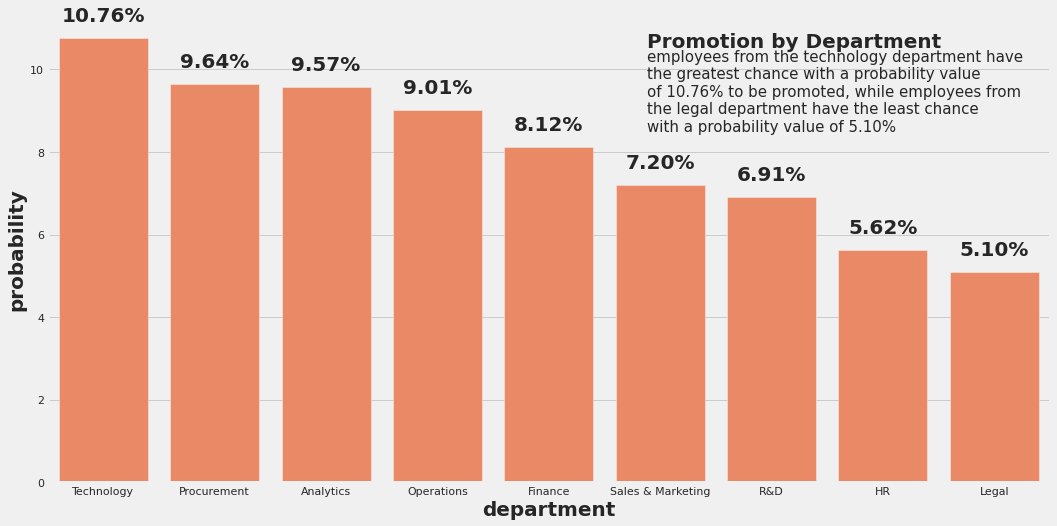

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan Department
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='department', y='probability', 
                data=data_department,ax=ax1,color='coral',
               order=data_department.sort_values('probability',ascending = False).department)

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.4,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=20,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Department'''
fig.text(x=0.6, y=0.825, s=title, fontsize=20, weight='bold')

#add description
text = '''
employees from the technology department have 
the greatest chance with a probability value 
of 10.76% to be promoted, while employees from
the legal department have the least chance 
with a probability value of 5.10%
'''
fig.text(x=0.6, y=0.65, s=text, fontsize=15)

#set y axis limit 
#plt.ylim(0, 20)

# add label
plt.xlabel('department', fontsize = 20, weight='bold')
plt.ylabel('probability', fontsize = 20, weight='bold')

plt.tight_layout
#plt.savefig('fig/Promotion by Department.png');

##### Probability to Get Promotion based on `education`
<a id = 'promoted_by_education' ></a>

In [ ]:
prob_edu = data.groupby(['education','is_promoted'])['employee_id'].count().reset_index()
edu = prob_edu.pivot_table(index='education', columns='is_promoted', 
                       values='employee_id').reset_index()
edu.columns = ['education', 'not_promoted', 'promoted']
edu['total'] = edu['not_promoted']+edu['promoted']
edu['probability'] = round((edu['promoted']/edu['total'])*100,2)
edu = edu.sort_values(['probability'], ascending=False)
edu

,education,not_promoted,promoted,total,probability
2,Master's & above,13454,1471,14925,9.86
1,Below Secondary,738,67,805,8.32
0,Bachelor's,33661,3008,36669,8.20


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

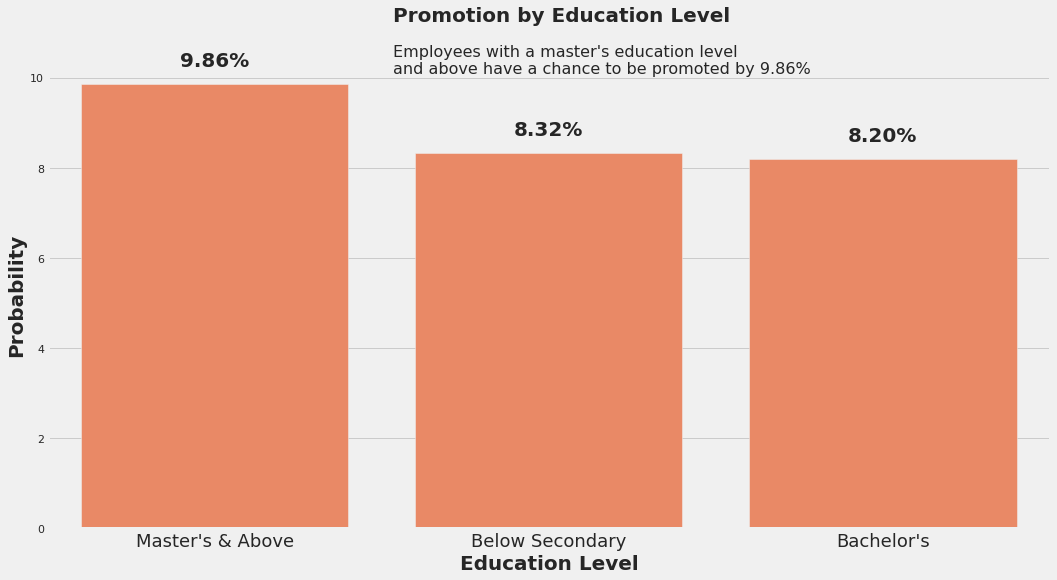

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan Kpi
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='education', y='probability', 
                data=edu,ax=ax1,color='coral',
               order=edu.sort_values('probability',ascending = False).education)

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.4,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=20,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Education Level'''
fig.text(x=0.38, y=0.95, s=title, fontsize=20, weight='bold')

#add description
text = '''
Employees with a master's education level
and above have a chance to be promoted by 9.86%
'''
fig.text(x=0.38, y=0.83, s=text, fontsize=16)

#set y axis limit 
#plt.ylim(0, 20)

# add label
plt.xlabel('Education Level', fontsize = 20, weight='bold')
plt.ylabel('Probability', fontsize = 20, weight='bold')
g.set_xticklabels(["Master's & Above", 'Below Secondary', "Bachelor's"], fontsize = 18)

plt.tight_layout
#plt.savefig('fig/Promotion by Education.png');

##### Probability to Get Promotion based on `gender`
<a id = 'promoted_by_gender' ></a>

In [ ]:
prob_gender = data.groupby(['gender','is_promoted'])['employee_id'].count().reset_index()
gender = prob_gender.pivot_table(index='gender', columns='is_promoted', 
                       values='employee_id').reset_index()
gender.columns = ['gender', 'not_promoted', 'promoted']
gender['total'] = gender['not_promoted']+gender['promoted']
gender['probability'] = round((gender['promoted']/gender['total'])*100,2)
gender = gender.sort_values(['probability'], ascending=False)
gender

,gender,not_promoted,promoted,total,probability
0,f,14845,1467,16312,8.99
1,m,35295,3201,38496,8.32


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

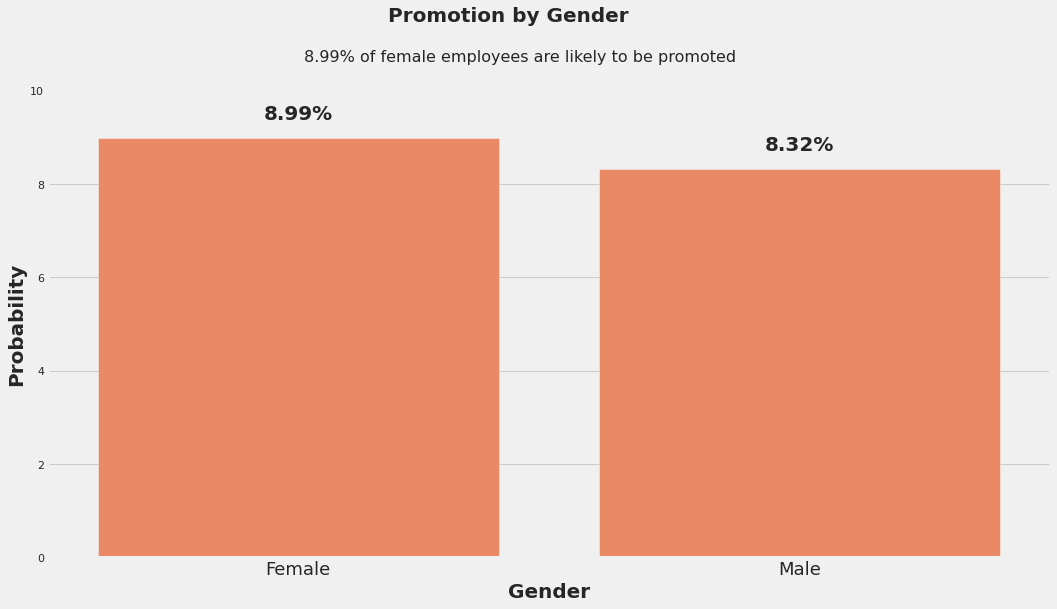

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan Kpi
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='gender', y='probability', 
                data=gender,ax=ax1,color='coral',
               order=gender.sort_values('probability',ascending = False).gender)

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.4,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=20,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Gender'''
fig.text(x=0.48, y=1, s=title, fontsize=20, weight='bold', ha='center')

#add description
text = '''
8.99% of female employees are likely to be promoted
'''
fig.text(x=0.49, y=0.9, s=text, fontsize=16, ha='center')

#set y axis limit 
plt.ylim(0, 10)

# add label
plt.xlabel('Gender', fontsize = 20, weight='bold')
plt.ylabel('Probability', fontsize = 20, weight='bold')
g.set_xticklabels(["Female", 'Male'], fontsize = 18)

plt.tight_layout
#plt.savefig('fig/Promotion by Gender.png');

##### Probability to Get Promotion based on `Gender` and `KPI`

In [ ]:
prob_gk = data.groupby(['gender','KPIs_met >80%','is_promoted'])['employee_id'].count().reset_index()
gk = prob_gk.pivot_table(index=['gender','KPIs_met >80%'], columns='is_promoted', 
                       values='employee_id').reset_index()
gk.columns = ['gender', 'kpi', 'not_promoted','promoted']
gk['total'] = gk['not_promoted']+gk['promoted']
gk['probability'] = round((gk['promoted']/gk['total'])*100,2)
gk['kpi'] = np.where(gk['kpi']==0, '<80%', '>80%')
gk

,gender,kpi,not_promoted,promoted,total,probability
0,f,<80%,9692,431,10123,4.26
1,f,>80%,5153,1036,6189,16.74
2,m,<80%,24419,975,25394,3.84
3,m,>80%,10876,2226,13102,16.99


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

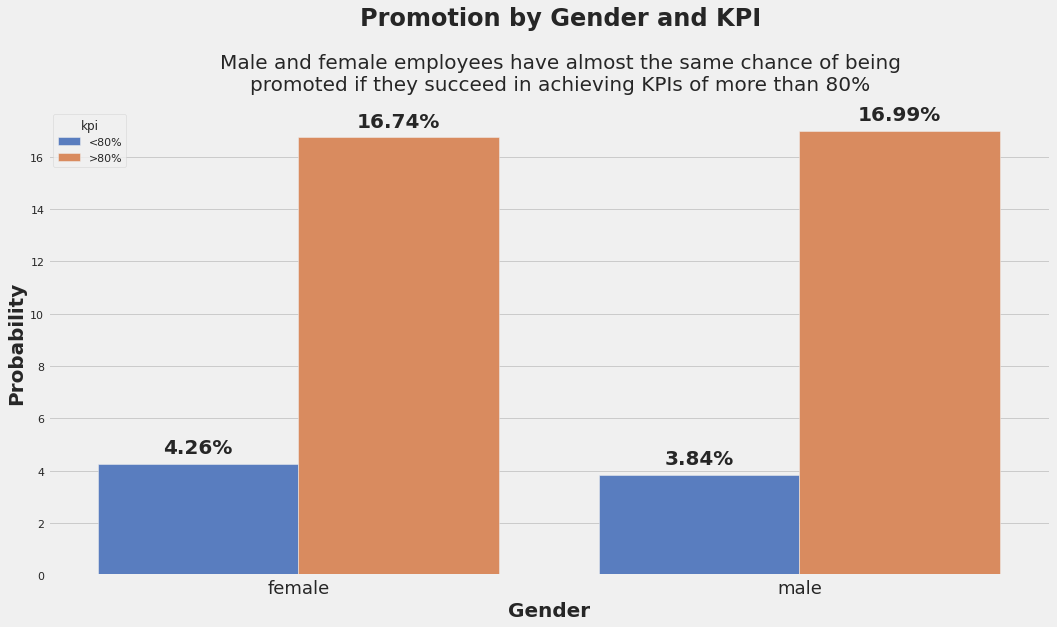

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan Kpi
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='gender', y='probability', hue='kpi',
                data=gk,ax=ax1,palette='muted')

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.4,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=20,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Gender and KPI'''
fig.text(x=0.525, y=1.025, s=title, fontsize=24, weight='bold',ha='center')

#add description
text = '''
Male and female employees have almost the same chance of being
promoted if they succeed in achieving KPIs of more than 80%
'''
fig.text(x=0.525, y=0.875, s=text, fontsize=20,ha='center')

#set y axis limit 
#plt.ylim(0, 20)

# add label
plt.xlabel('Gender', fontsize = 20, weight='bold')
plt.ylabel('Probability', fontsize = 20, weight='bold')
g.set_xticklabels(['female', 'male'], fontsize = 18)

plt.tight_layout
#plt.savefig('fig/Gender-KPI probability.png');

##### Probability to Get Promotion based on `Average_Training_Score` and `KPI`

In [ ]:
data['hs'] = np.where(data['avg_training_score']>=90, 1, 0)
prob_tk = data.groupby(['hs','KPIs_met >80%','is_promoted'])['employee_id'].count().reset_index()
tk = prob_tk.pivot_table(index=['hs','KPIs_met >80%'], columns='is_promoted', 
                       values='employee_id').reset_index()
tk.columns = ['high_score', 'kpi', 'not_promoted','promoted']
tk['total'] = tk['not_promoted']+tk['promoted']
tk['probability'] = round((tk['promoted']/tk['total'])*100,2)
tk['kpi'] = np.where(tk['kpi']==0, '<80%', '>80%')
tk

,high_score,kpi,not_promoted,promoted,total,probability
0,0,<80%,33994,1202,35196,3.42
1,0,>80%,15969,2879,18848,15.27
2,1,<80%,117,204,321,63.55
3,1,>80%,60,383,443,86.46


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

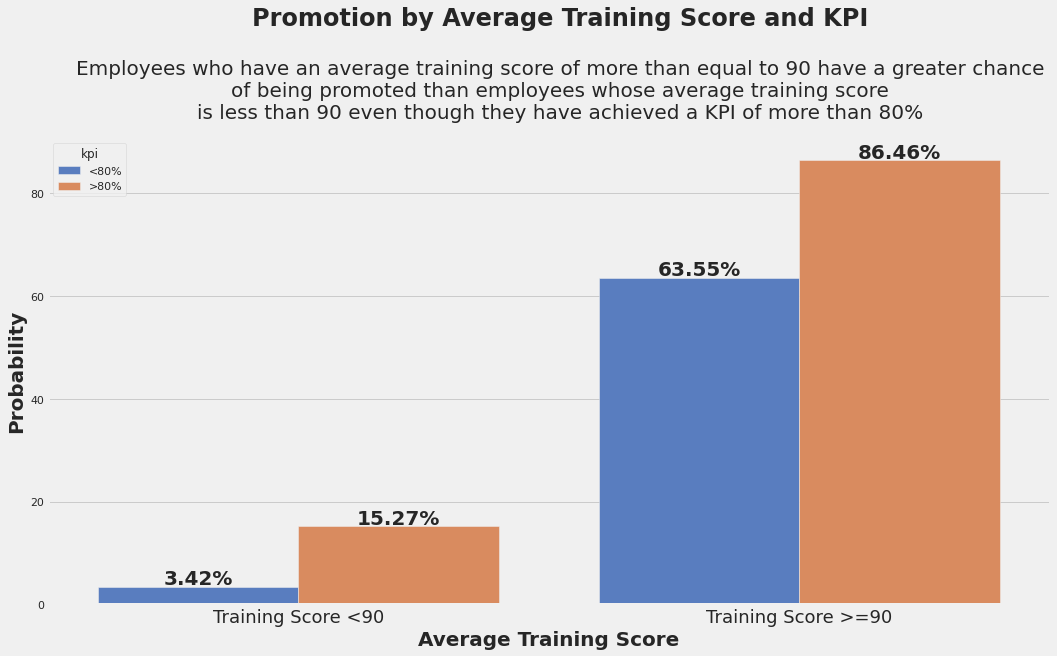

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan Kpi
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='high_score', y='probability', hue='kpi',
                data=tk,ax=ax1,palette='muted')

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.4,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=20,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Average Training Score and KPI'''
fig.text(x=0.525, y=1.075, s=title, fontsize=24, weight='bold',ha='center')

#add description
text = '''
Employees who have an average training score of more than equal to 90 have a greater chance
of being promoted than employees whose average training score
is less than 90 even though they have achieved a KPI of more than 80%
'''
fig.text(x=0.525, y=0.875, s=text, fontsize=20,ha='center')

#set y axis limit 
#plt.ylim(0, 20)

# add label
plt.xlabel('Average Training Score', fontsize = 20, weight='bold')
plt.ylabel('Probability', fontsize = 20, weight='bold')
g.set_xticklabels(['Training Score <90', 'Training Score >=90'], fontsize = 18)

plt.tight_layout
#plt.savefig('fig/Training-KPI Probability.png');

##### Probability to Get Promotion based on `Department` and `KPI`

In [ ]:
prob_dk = data.groupby(['department','KPIs_met >80%','is_promoted'])['employee_id'].count().reset_index()
dk = prob_dk.pivot_table(index=['department','KPIs_met >80%'], columns='is_promoted', 
                       values='employee_id').reset_index()
dk.columns = ['department', 'kpi', 'not_promoted','promoted']
dk['total'] = dk['not_promoted']+dk['promoted']
dk['probability'] = round((dk['promoted']/dk['total'])*100,2)
dk['kpi'] = np.where(dk['kpi']==0, '<80%', '>80%')
dk = dk.sort_values(['probability'], ascending=False)
dk

,department,kpi,not_promoted,promoted,total,probability
17,Technology,>80%,1923,535,2458,21.77
15,Sales & Marketing,>80%,3604,860,4464,19.27
11,Procurement,>80%,2195,500,2695,18.55
1,Analytics,>80%,1808,355,2163,16.41
9,Operations,>80%,4190,698,4888,14.28
3,Finance,>80%,922,130,1052,12.36
13,R&D,>80%,366,50,416,12.02
5,HR,>80%,713,95,808,11.76
7,Legal,>80%,308,39,347,11.24
2,Finance,<80%,1408,76,1484,5.12


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

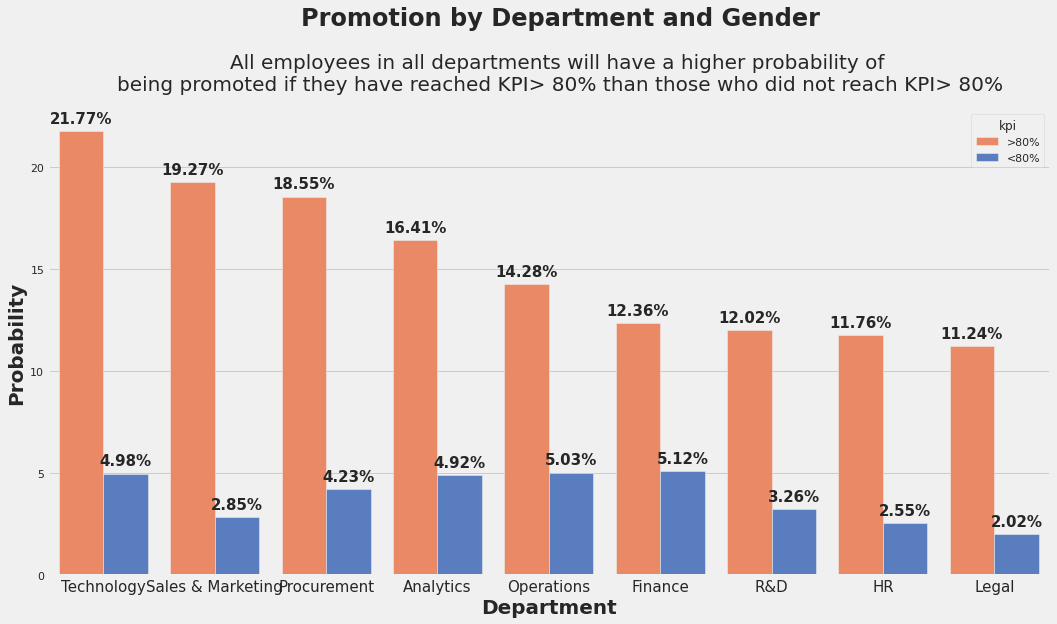

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan Kpi
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='department', y='probability', hue='kpi',
                data=dk,ax=ax1,palette=['coral','#4878D0'])

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.4,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=15,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Department and Gender'''
fig.text(x=0.525, y=1.025, s=title, fontsize=24, weight='bold',ha='center')

#add description
text = '''
All employees in all departments will have a higher probability of 
being promoted if they have reached KPI> 80% than those who did not reach KPI> 80%
'''
fig.text(x=0.525, y=0.875, s=text, fontsize=20,ha='center')

#set y axis limit 
#plt.ylim(0, 20)

# add label
plt.xlabel('Department', fontsize = 20, weight='bold')
plt.ylabel('Probability', fontsize = 20, weight='bold')
g.set_xticklabels(['Technology','Sales & Marketing','Procurement',
                   'Analytics','Operations','Finance','R&D','HR','Legal'], fontsize = 15)

plt.tight_layout
#plt.savefig('fig/department-gender Probability.png');

##### Probability to Get Promotion based on `Department` and `Gender`

In [ ]:
prob_dg = data.groupby(['department','gender','is_promoted'])['employee_id'].count().reset_index()
dg = prob_dg.pivot_table(index=['department','gender'], columns='is_promoted', 
                       values='employee_id').reset_index()
dg.columns = ['department', 'gender', 'not_promoted','promoted']
dg['total'] = dg['not_promoted']+dg['promoted']
dg['probability'] = round((dg['promoted']/dg['total'])*100,2)
dg['gender'] = np.where(dg['gender']=='m', 'male', 'female')
dg = dg.sort_values(['probability'], ascending=False)
dg

,department,gender,not_promoted,promoted,total,probability
0,Analytics,female,451,62,513,12.09
10,Procurement,female,2902,385,3287,11.71
17,Technology,male,3859,491,4350,11.29
12,R&D,female,51,6,57,10.53
16,Technology,female,2511,277,2788,9.94
8,Operations,female,4235,442,4677,9.45
1,Analytics,male,4389,450,4839,9.30
9,Operations,male,6090,581,6671,8.71
3,Finance,male,1704,151,1855,8.14
2,Finance,female,626,55,681,8.08


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

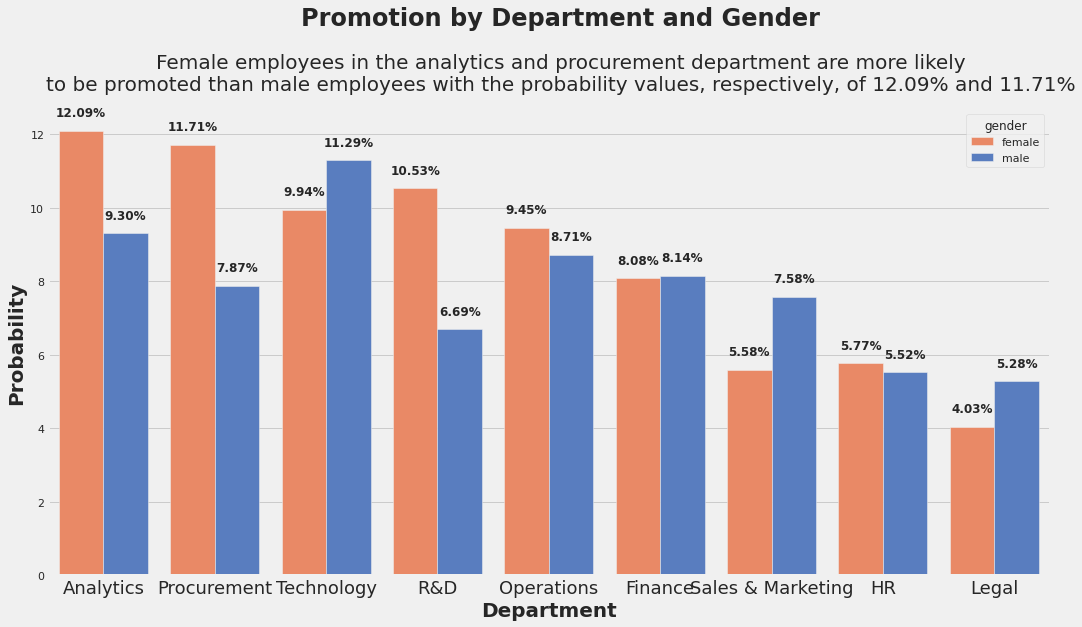

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan Kpi
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='department', y='probability', hue='gender',
                data=dg,ax=ax1,palette=['coral','#4878D0'])

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.4,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=12,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Department and Gender'''
fig.text(x=0.525, y=1.025, s=title, fontsize=24, weight='bold',ha='center')

#add description
text = '''
Female employees in the analytics and procurement department are more likely
to be promoted than male employees with the probability values, respectively, of 12.09% and 11.71%
'''
fig.text(x=0.525, y=0.875, s=text, fontsize=20,ha='center')

#set y axis limit 
#plt.ylim(0, 20)

# add label
plt.xlabel('Department', fontsize = 20, weight='bold')
plt.ylabel('Probability', fontsize = 20, weight='bold')
g.set_xticklabels(['Analytics','Procurement','Technology',
                   'R&D','Operations','Finance','Sales & Marketing','HR','Legal'], fontsize = 18)

plt.tight_layout
#plt.savefig('fig/department-gender Probability.png');

##### Probability to Get Promotion based on `Award` and `KPI`

In [ ]:
prob_ak = data.groupby(['awards_won?','KPIs_met >80%','is_promoted'])['employee_id'].count().reset_index()
ak = prob_ak.pivot_table(index=['awards_won?','KPIs_met >80%'], columns='is_promoted', 
                       values='employee_id').reset_index()
ak.columns = ['won_awards', 'kpi', 'not_promoted','promoted']
ak['total'] = ak['not_promoted']+ak['promoted']
ak['probability'] = round((ak['promoted']/ak['total'])*100,2)
ak['won_awards'] = np.where(ak['won_awards']==0, 'No', 'Yes')
ak['kpi'] = np.where(ak['kpi']==0, '<80%', '>80%')
ak = ak.sort_values(['probability'], ascending=False)
ak

,won_awards,kpi,not_promoted,promoted,total,probability
2,Yes,<80%,202,239,441,54.20
3,Yes,>80%,509,320,829,38.60
1,No,>80%,15520,2942,18462,15.94
0,No,<80%,33909,1167,35076,3.33


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

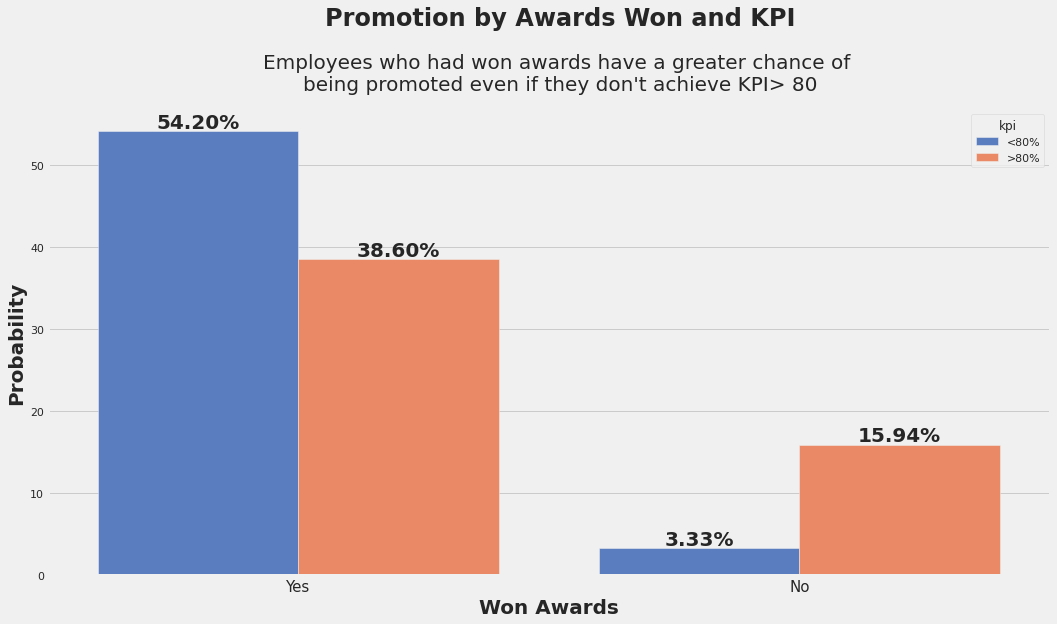

In [ ]:
#melihat jumlah karyawan yang dipromosikan berdasarkan Kpi
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
g = sns.barplot(x='won_awards', y='probability', hue='kpi',
                data=ak,ax=ax1,palette=['#4878D0','coral'])

#add percentage labels
for p in g.patches:
    height = p.get_height()
    g.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.4,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center',
                fontsize=20,
                weight='bold')
    
plt.xticks(rotation=0)

#add title
title = '''Promotion by Awards Won and KPI'''
fig.text(x=0.525, y=1.025, s=title, fontsize=24, weight='bold',ha='center')

#add description
text = '''
Employees who had won awards have a greater chance of 
being promoted even if they don't achieve KPI> 80
'''
fig.text(x=0.525, y=0.875, s=text, fontsize=20,ha='center')

#set y axis limit 
#plt.ylim(0, 20)

# add label
plt.xlabel('Won Awards', fontsize = 20, weight='bold')
plt.ylabel('Probability', fontsize = 20, weight='bold')
g.set_xticklabels(['Yes','No'], fontsize = 15)

plt.tight_layout
#plt.savefig('fig/awards-kpi Probability.png');

# Data Preparation

## Fix The Duplicate Values

In [ ]:
data_clean = data.copy()
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
 14  hs                    54808 non-null  int64  
dtypes: float64(1), int6

In [ ]:
data_clean.duplicated().sum()

0

**there are no duplicate from this dataset**

## Fix The Missing Value

**Remove `employee_id` since every rows have each unique values***</br>

From this step, the dataset is changed into new object called `data_clean`
* `data_clean` was created to save the clean data (fix missing value and duplicated data)
* The *feature engineering* results will be saved into `data_clean`

In [ ]:
data_clean['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

__*Fix the missing value in `education` feature with `mode()` function to fill them with the most frequently occuring values*__

In [ ]:
data_clean['education'] = data_clean['education'].fillna(data_clean['education'].mode()[0])

In [ ]:
data_clean['education'].value_counts()

Bachelor's          39078
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

__*Fix the missing value in `previous_year_rating` feature with `median()` function to fill them with the median values. The reason is the distribution of this feature looks normal (the `mean` value and `median` value is close enough)*__

In [ ]:
data_clean['previous_year_rating'].fillna(data_clean['previous_year_rating'].median(), inplace=True)

In [ ]:
data_clean.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
hs                      0
dtype: int64

## Feature Engineering

Based on the dataset, we decided to create 4 new features using the data from existing features

1. `potential_region`: contains the information of whether an employee was placed in potential region to be promoted or not
2. `performance_level`: contains the information that show the performance level of an employee. This feature comes from combination of `previous_year_rating`, `KPIs_met >80%`, and `awards_won?`
3. `High_Avg_Tscore`: contains the information of whether the average training score of an employee is high enough for promotion chance based on the previous data
4. `male`: contains the information to show an employee gender

### `potential_region`

*Contains the information of whether an employee was placed in potential region to be promoted or not*</br>
**1. based on the probability information on [promoted_by_region](#promoted_by_region), there are 8 regions that have a higher potential than other regions, namely with a probability value> 10%**</br>
**2. The regions are 4, 17, 25, 28, 23, 22, 3, 7 (in the order starting from the one with the highest probability value)**</br>
**3. if the employee is in the region, it will have a value of '1' otherwise it will be worth '0'**


In [ ]:
data_cat = data_clean.select_dtypes(include=['object'])
data_cat_unique = data_cat.nunique().reset_index()
data_cat_unique.columns = ['fitur', 'unik nilai']
data_cat_unique = data_cat_unique.sort_values('unik nilai', ascending=False)
data_cat_unique

,fitur,unik nilai
1,region,34
0,department,9
2,education,3
4,recruitment_channel,3
3,gender,2


In [ ]:
data_clean['potential_region'] = np.where(data_clean['region'].isin(['region_4','region_17','region_25','region_28','region_23',
                                                   'region_3','region_7']),
                              1, 0)
data_clean.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,hs,potential_region
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,0,1
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,0,1
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,0,0


In [ ]:
data_cat = data_clean.select_dtypes(include=['object'])
data_cat_unique = data_cat.nunique().reset_index()
data_cat_unique.columns = ['fitur', 'unik nilai']
data_cat_unique = data_cat_unique.sort_values('unik nilai', ascending=False)
data_cat_unique

,fitur,unik nilai
1,region,34
0,department,9
2,education,3
4,recruitment_channel,3
3,gender,2


In [ ]:

potential_reg_probs = data_clean.groupby(['potential_region', 'is_promoted']).agg({
    'department': ['count']
}).reset_index()

potential_reg_probs.columns = ['potential_region', 'is_promoted','employees']

potential_reg_probs = pd.pivot_table(potential_reg_probs,
                             index = 'potential_region',
                             columns = 'is_promoted',
                             values = 'employees').reset_index()

potential_reg_probs.columns = ['potential_region','not_promoted','promoted']
potential_reg_probs['total_employees'] = potential_reg_probs['not_promoted'] + potential_reg_probs['promoted']
potential_reg_probs['promotion_probs'] = (potential_reg_probs['promoted']/(potential_reg_probs['not_promoted']+potential_reg_probs['promoted']))*100
potential_reg_probs = potential_reg_probs.sort_values('promotion_probs', ascending=False).reset_index(drop=True)
potential_reg_probs['potential_region'] = np.where(potential_reg_probs['potential_region'] == 1, 'YES', 'NO')
potential_reg_probs

,potential_region,not_promoted,promoted,total_employees,promotion_probs
0,YES,9698,1302,11000,11.836364
1,NO,40442,3366,43808,7.683528


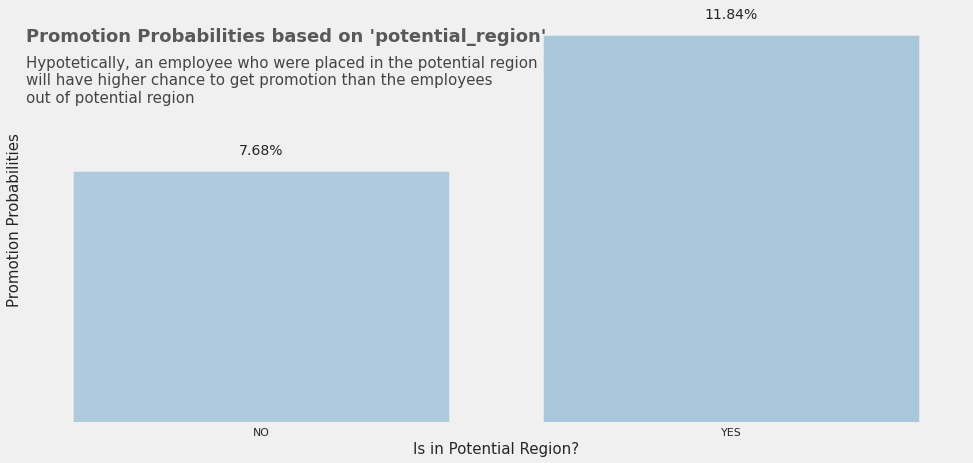

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

g = sns.barplot(x='potential_region', y='promotion_probs', data=potential_reg_probs,
                order=potential_reg_probs.sort_values('promotion_probs')['potential_region'],
                palette=sns.color_palette("Blues_d", n_colors=40, desat=1)
               )

for p in g.patches:
    height = p.get_height()
    plt.text(x = p.get_x() + (p.get_width()/2),
           y = height + 0.5,
           s = str('{:.2f}'.format(height)) + '%',
           ha = 'center'
          )

title = '''
Promotion Probabilities based on 'potential_region'
'''

text = '''
Hypotetically, an employee who were placed in the potential region
will have higher chance to get promotion than the employees 
out of potential region
'''

plt.yticks([]) # Hide the y-axis with empty list
plt.xlabel('Is in Potential Region?', fontsize = 15) # Add the x-label
plt.ylabel('Promotion Probabilities', fontsize = 15) # Add the y-label

plt.text(x = -0.5, y = 11, s=title,
        fontsize = 18, weight = 'bold', alpha = .75)
plt.text(x = -0.5, y = 9.25, s=text,
        fontsize = 15, alpha = .85);

#plt.savefig('fig/Insight Awal ke-3.png')

### `performance_level`

This feature comes from combination of `previous_year_rating`, `KPIs_met >80%`, and `awards_won?`

Based on the probability obtained in [promoted_by_kpi](#promoted_by_kpi), [previous_year_rating](#previous_year_rating), and [awards_won?](#awards_won?) have been shown that the probability will be higher if an employee met this 3 conditions

1. An employee who met their KPI > 80 % has higher chance to get promotion than others who didn't met their KPI
2. An employee who got 5 rating in the previous year has 9% higher chance to get promoted than others
3. An employee who won any award in the previous year has 36% higher chance to get promotion thanothers

This feature will have performance level as its value, from 1 `(low)` to 4 `(best)`, with the provisions below:
- if KPIs_met = 1 & rating = 5 & awards_won = 1, then `4 (Best)`
- if KPIs_met = 1 & rating = 4/5 & awards_won = 1/0, then `3 (Better)`
- if KPIs_met = 1 & rating = 3 & awards_won = 1/0, then `2 (Good)`
- else `1 (Low)`


In [ ]:
# membuat fitur performance_level
data_clean['performance_level'] = np.where(
    (
        (data_clean['previous_year_rating'] == 5) &
        (data_clean['KPIs_met >80%'] == 1) &
        (data_clean['awards_won?'] == 1)
    ),
"Best",
    np.where((
        ((data_clean['previous_year_rating'] == 4) & (data_clean['KPIs_met >80%'] == 0) & (data_clean['awards_won?'] == 1)) | 
        ((data_clean['previous_year_rating'] == 4) & (data_clean['KPIs_met >80%'] == 1) & (data_clean['awards_won?'] == 0)) |
        ((data_clean['previous_year_rating'] == 4) & (data_clean['KPIs_met >80%'] == 1) & (data_clean['awards_won?'] == 1)) |
        ((data_clean['previous_year_rating'] == 5) & (data_clean['KPIs_met >80%'] == 0) & (data_clean['awards_won?'] == 1)) |
        ((data_clean['previous_year_rating'] == 5) & (data_clean['KPIs_met >80%'] == 1) & (data_clean['awards_won?'] == 0))
    ),
    "Better",
    np.where(
        ((data_clean['previous_year_rating'] == 3) & (data_clean['KPIs_met >80%'] == 0) & (data_clean['awards_won?'] == 1)) | 
        ((data_clean['previous_year_rating'] == 3) & (data_clean['KPIs_met >80%'] == 1) & (data_clean['awards_won?'] == 0)) |
        ((data_clean['previous_year_rating'] == 3) & (data_clean['KPIs_met >80%'] == 1) & (data_clean['awards_won?'] == 1)),
        "Good","Low"
    )
    )
)

In [ ]:

perform_probs = data_clean.groupby(['performance_level', 'is_promoted']).agg({
    'department': ['count']
}).reset_index()

perform_probs.columns = ['performance_level', 'is_promoted','employees']

perform_probs = pd.pivot_table(perform_probs,
                             index = 'performance_level',
                             columns = 'is_promoted',
                             values = 'employees').reset_index()

perform_probs.columns = ['performance_level','not_promoted','promoted']
perform_probs['total_employees'] = perform_probs['not_promoted'] + perform_probs['promoted']
perform_probs['promotion_probs'] = (perform_probs['promoted']/(perform_probs['not_promoted']+perform_probs['promoted']))*100
perform_probs = perform_probs.sort_values('promotion_probs', ascending=False).reset_index(drop=True)
perform_probs

,performance_level,not_promoted,promoted,total_employees,promotion_probs
0,Best,114,125,239,52.301255
1,Good,5203,1232,6435,19.145299
2,Better,9460,1953,11413,17.112065
3,Low,35363,1358,36721,3.698156


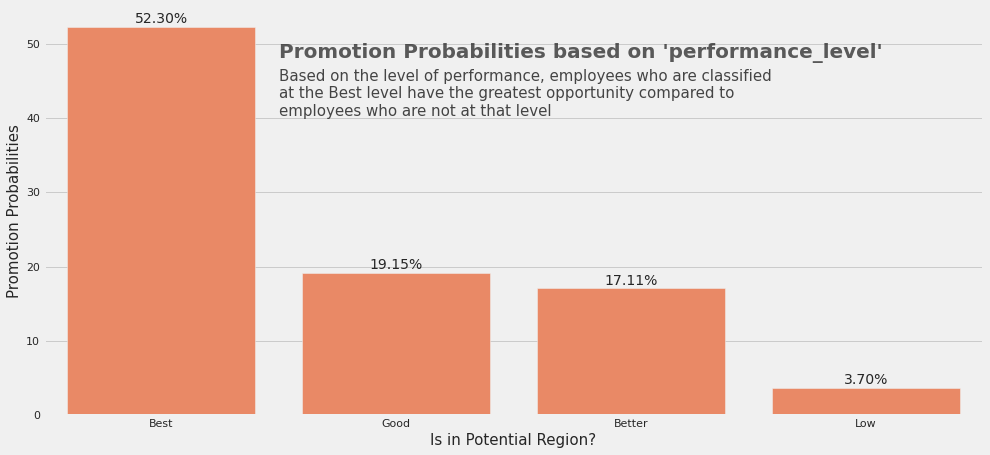

In [ ]:
#melihat peluang yang dipromosikan berdasarkan performance_level
fig, ax = plt.subplots(figsize=(15,7))

g = sns.barplot(x='performance_level', y='promotion_probs', data=perform_probs,
                order=perform_probs.sort_values('promotion_probs',ascending = False).performance_level,
                color='coral'
               )

for p in g.patches:
    height = p.get_height()
    plt.text(x = p.get_x() + (p.get_width()/2),
           y = height + 0.5,
           s = str('{:.2f}'.format(height)) + '%',
           ha = 'center'
          )

title = '''
Promotion Probabilities based on 'performance_level'
'''

text = '''
Based on the level of performance, employees who are classified
at the Best level have the greatest opportunity compared to 
employees who are not at that level
'''

#plt.yticks([]) # Hide the y-axis with empty list
plt.xlabel('Is in Potential Region?', fontsize = 15) # Add the x-label
plt.ylabel('Promotion Probabilities', fontsize = 15) # Add the y-label

plt.text(x = 0.5, y = 45, s=title,
        fontsize = 20, weight = 'bold', alpha = .75)
plt.text(x = 0.5, y = 38, s=text,
        fontsize = 15, alpha = .85);

#plt.savefig('fig/Promotion by Performance Level.png')

### `High_Avg_Tscore`

This feature will have information on whether an employee has an average training score of more than or equal to 90 which has a greater chance of getting a promotion
1. based on the probability information on [avg_training_score](#avg_training_score), the opportunity for employees with a value greater than 90 is 76.83%
2. If the employee has this value then the value is '1' otherwise it will be worth '0'

In [ ]:
data_clean['High_Avg_Tscore'] = np.where(data_clean['avg_training_score']>=90, 1, 0)
data_clean.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,hs,potential_region,performance_level,High_Avg_Tscore
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,0,1,Better,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,0,0,Low,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,0,0,Low,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,0,1,Low,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,0,0,Low,0


### `male`

*Contains the information to show an employee gender from `gender` feature*
1. If the `gender` value is `m`, `male` feature will have value `1`, if not the value will be set to `0`
2. This is to reduce the feature encoding results that may be affect the number of feature


In [ ]:
data_clean['male'] = np.where(data_clean['gender']=='m', 1, 0)
data_clean.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,hs,potential_region,performance_level,High_Avg_Tscore,male
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,0,1,Better,0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,0,0,Low,0,1
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,0,0,Low,0,1
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,0,1,Low,0,1
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,0,0,Low,0,1


## Feature encoding
*To convert the categorical data into numerical format. The goal is to get the optimum learning process of our model. The technique we choose is `one-hot-encoding`. The reason is the cardinality of the categorical data is not too large*

### `department`

In [ ]:
dummies_dept = pd.get_dummies(data_clean['department'], prefix='Dept')
data_clean = pd.concat([data_clean, dummies_dept], axis=1)

### `education`

In [ ]:
dummies_edu = pd.get_dummies(data_clean['education'])
data_clean = pd.concat([data_clean, dummies_edu], axis=1)

### `recruitment_channel`

In [ ]:
dummies_rc = pd.get_dummies(data_clean['recruitment_channel'])
data_clean = pd.concat([data_clean, dummies_rc], axis=1)

### `performance_level`

In [ ]:
#merubah fitur performance_level dari data categorical menjadi numerik menggunakan metode one hot encoding
dummies_pl = pd.get_dummies(data_clean['performance_level'])
data_clean = pd.concat([data_clean, dummies_pl], axis=1)

In [ ]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   employee_id             54808 non-null  int64  
 1   department              54808 non-null  object 
 2   region                  54808 non-null  object 
 3   education               54808 non-null  object 
 4   gender                  54808 non-null  object 
 5   recruitment_channel     54808 non-null  object 
 6   no_of_trainings         54808 non-null  int64  
 7   age                     54808 non-null  int64  
 8   previous_year_rating    54808 non-null  float64
 9   length_of_service       54808 non-null  int64  
 10  KPIs_met >80%           54808 non-null  int64  
 11  awards_won?             54808 non-null  int64  
 12  avg_training_score      54808 non-null  int64  
 13  is_promoted             54808 non-null  int64  
 14  hs                      54808 non-null

## Logaritmik

__*From this step, we use `df_pre` as the dataset. At the beginning, this dataset was copied from `data_clean`. So this `df_pre` will be used to save the log transformation result, norm/std results*__


In [ ]:
features = ['no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?',
            'avg_training_score','is_promoted','potential_region','Dept_Analytics','Dept_Finance','Dept_HR','Dept_Legal',
            'Dept_Operations','Dept_Procurement','Dept_R&D','Dept_Sales & Marketing','Dept_Technology',"Bachelor's",
            'Below Secondary',"Master's & above", 'other','referred','sourcing','male','High_Avg_Tscore','Best','Better','Good','Low']

df_pre = data_clean.copy()
for var in features:
    df_pre['log_'+var]= (data_clean[var]+1).apply(np.log)

In [ ]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 68 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   employee_id                 54808 non-null  int64  
 1   department                  54808 non-null  object 
 2   region                      54808 non-null  object 
 3   education                   54808 non-null  object 
 4   gender                      54808 non-null  object 
 5   recruitment_channel         54808 non-null  object 
 6   no_of_trainings             54808 non-null  int64  
 7   age                         54808 non-null  int64  
 8   previous_year_rating        54808 non-null  float64
 9   length_of_service           54808 non-null  int64  
 10  KPIs_met >80%               54808 non-null  int64  
 11  awards_won?                 54808 non-null  int64  
 12  avg_training_score          54808 non-null  int64  
 13  is_promoted                 548

In [ ]:
df_pre.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,hs,...,log_Master's & above,log_other,log_referred,log_sourcing,log_male,log_High_Avg_Tscore,log_Best,log_Better,log_Good,log_Low
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,...,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170,0.013940,...,0.188721,0.384766,0.014450,0.293701,0.486852,0.009662,0.003023,0.144409,0.081360,0.464355
std,22586.581449,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137,0.117241,...,0.308594,0.344482,0.098999,0.342529,0.316918,0.081265,0.045715,0.281494,0.223145,0.325928
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000,0.000000,...,0.000000,0.693359,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.693359
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000,0.000000,...,0.693359,0.693359,0.000000,0.693359,0.693147,0.000000,0.000000,0.000000,0.000000,0.693359
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000,1.000000,...,0.693359,0.693359,0.693359,0.693359,0.693147,0.693147,0.693359,0.693359,0.693359,0.693359


## Normalization

In [ ]:
for var in features:
    df_pre['nor_'+var] = MinMaxScaler().fit_transform(df_pre[var].values.reshape(len(df_pre),1))

In [ ]:
df_pre

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,...,nor_Master's & above,nor_other,nor_referred,nor_sourcing,nor_male,nor_High_Avg_Tscore,nor_Best,nor_Better,nor_Good,nor_Low
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
54806,13614,Sales & Marketing,region_9,Bachelor's,m,sourcing,1,29,1.0,2,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


# Machine Learning Modelling and Evaluation

## Split Train & Test

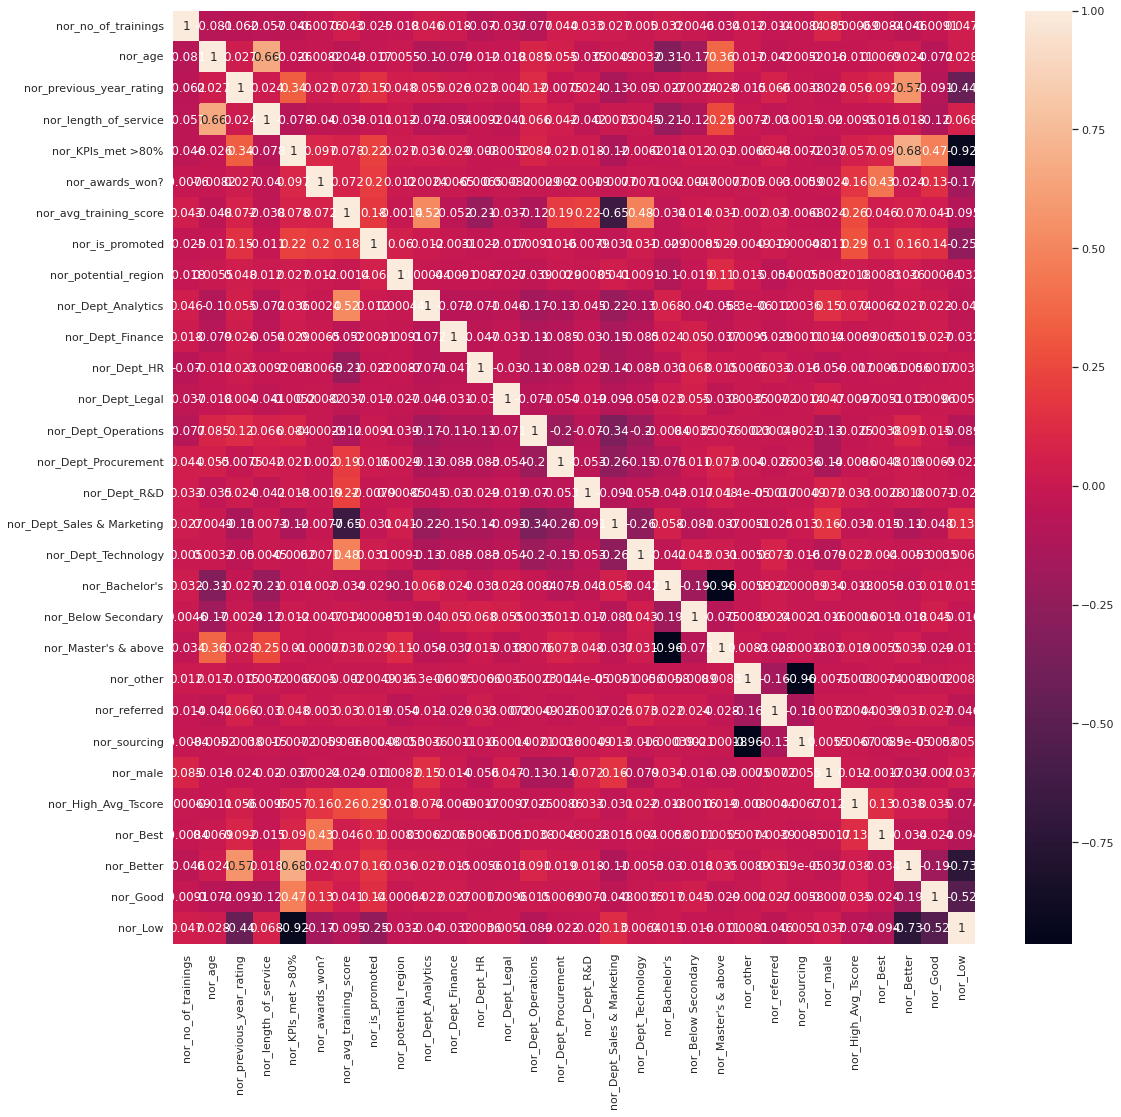

In [ ]:
sns.set(rc={'figure.figsize':(16,16)})
sns.heatmap(df_pre[['nor_no_of_trainings','nor_age','nor_previous_year_rating',
                    'nor_length_of_service','nor_KPIs_met >80%','nor_awards_won?',
                    'nor_avg_training_score','nor_is_promoted','nor_potential_region',
                    'nor_Dept_Analytics','nor_Dept_Finance','nor_Dept_HR','nor_Dept_Legal',
                    'nor_Dept_Operations','nor_Dept_Procurement','nor_Dept_R&D',
                    'nor_Dept_Sales & Marketing','nor_Dept_Technology',"nor_Bachelor's",
                    'nor_Below Secondary',"nor_Master's & above", 'nor_other','nor_referred',
                    'nor_sourcing','nor_male','nor_High_Avg_Tscore','nor_Best','nor_Better',
                    'nor_Good','nor_Low']].corr(), annot=True)
#plt.savefig('fig/split train test.png')

In [ ]:
x_norm = df_pre[['nor_no_of_trainings','nor_age','nor_previous_year_rating',
            'nor_length_of_service','nor_KPIs_met >80%','nor_awards_won?',
            'nor_avg_training_score','nor_potential_region',
            'nor_Dept_Analytics','nor_Dept_Finance','nor_Dept_HR','nor_Dept_Legal',
            'nor_Dept_Operations','nor_Dept_Procurement','nor_Dept_R&D',
            'nor_Dept_Sales & Marketing','nor_Dept_Technology',"nor_Bachelor's",
            'nor_Below Secondary',"nor_Master's & above", 'nor_other','nor_referred',
            'nor_sourcing','nor_male','nor_High_Avg_Tscore',"nor_Best",'nor_Better','nor_Good','nor_Low']]
y_norm = df_pre['nor_is_promoted']

In [ ]:
#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x_norm,
                                                y_norm,
                                                test_size=0.2, random_state=42) 

In [ ]:
df_pre.shape

(54808, 98)

In [ ]:
xtrain.shape

(43846, 29)

In [ ]:
xtest.shape

(10962, 29)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier (random_state=42)
rf_model = rf.fit(xtrain, ytrain)

In [ ]:
y_predicted = rf.predict(xtest)
y_predicted_train = rf.predict(xtrain)
#eval
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

print('\nclassification report')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Random Forest: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Random Forest: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97     10054
         1.0       0.73      0.33      0.46       908

    accuracy                           0.93     10962
   macro avg       0.84      0.66      0.71     10962
weighted avg       0.92      0.93      0.92     10962

Random Forest: ROC AUC =  66.1 %
Random Forest: Precision =  72.8 %
Random Forest: Recall =  33.4 %
Random Forest: Accuracy =  93.5 %
Random Forest: F1-Score =  45.8 %


array([[9941,  113],
       [ 605,  303]])

In [ ]:
#Save Machine Learning Model
import pickle
pickle.dump(rf_model, open('RandomForest.pkl', 'wb'))

In [ ]:
#Load and print model score
loaded_model = pickle.load(open('RandomForest.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.9345010034665208


In [ ]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  99.78 %
test score :  93.45 %


In [ ]:
#define function for roc auc curve
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

ROC AUC Score:  66.1 %


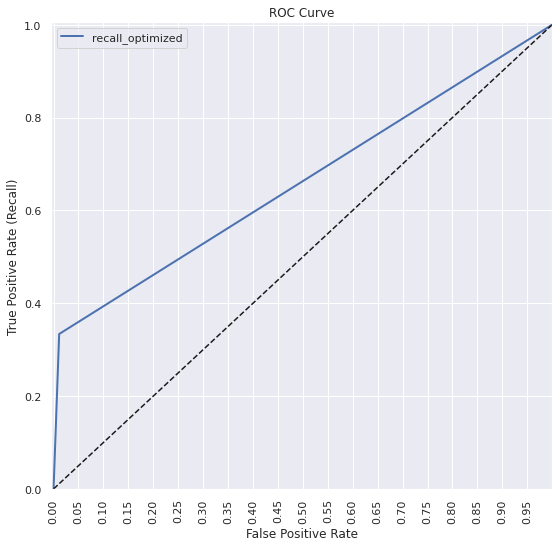

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/Random Forest ROC Curve.png')

In [ ]:
#Define function to see precision and recall threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [ ]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_predicted)

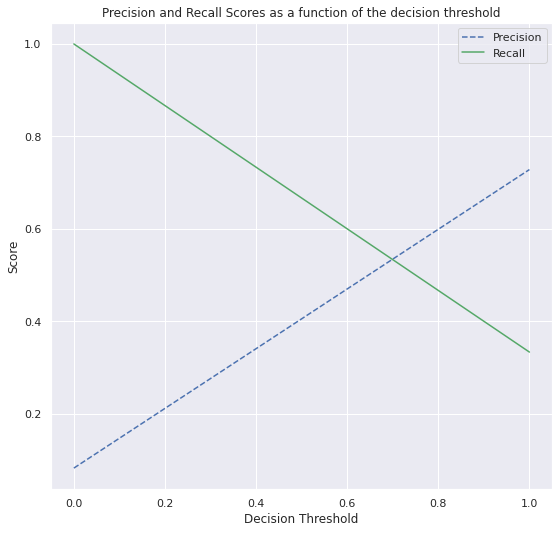

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold RF.png')

## K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_model = knn.fit(xtrain, ytrain)

In [ ]:
# Predict Test
ypredicted = knn.predict(xtest)

print('\nclassification report')
print(classification_report(ytest, ypredicted)) # generate the precision, recall, f-1 score, num
print('KNN: ROC AUC = ',str(round(roc_auc_score(ytest, ypredicted)*100,1)), '%')
print('KNN: Precision = ',str(round(precision_score(ytest, ypredicted)*100,1)), '%')
print('KNN: Recall = ',str(round(recall_score(ytest, ypredicted)*100,1)), '%')
print('KNN: Accuracy = ',str(round(accuracy_score(ytest, ypredicted)*100,1)), '%')
print('KNN: F1-Score = ',str(round(f1_score(ytest, ypredicted)*100,1)), '%')
confusion_matrix(ytest, ypredicted)


classification report
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     10054
         1.0       0.63      0.21      0.32       908

    accuracy                           0.92     10962
   macro avg       0.78      0.60      0.64     10962
weighted avg       0.91      0.92      0.91     10962

KNN: ROC AUC =  60.2 %
KNN: Precision =  62.9 %
KNN: Recall =  21.5 %
KNN: Accuracy =  92.4 %
KNN: F1-Score =  32.0 %


array([[9939,  115],
       [ 713,  195]])

In [ ]:
#Save Machine Learning Model
import pickle
pickle.dump(knn_model, open('KNN.pkl', 'wb'))

In [ ]:
#Load and print model score
loaded_model = pickle.load(open('KNN.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.9244663382594417


In [ ]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  93.6 %
test score :  92.45 %


ROC AUC Score:  60.2 %


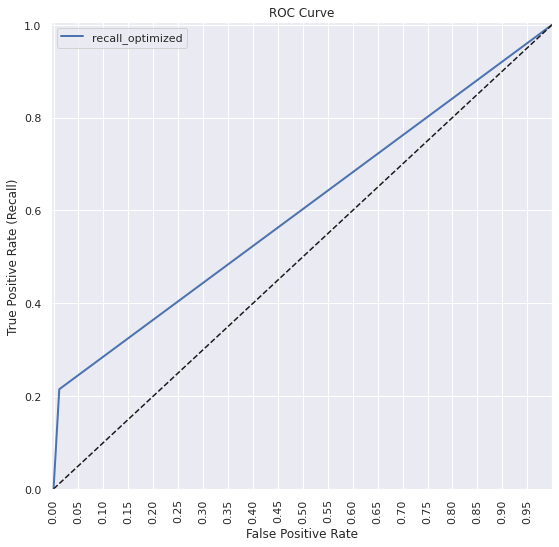

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, ypredicted)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/KNN ROC Curve.png')

In [ ]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, ypredicted)

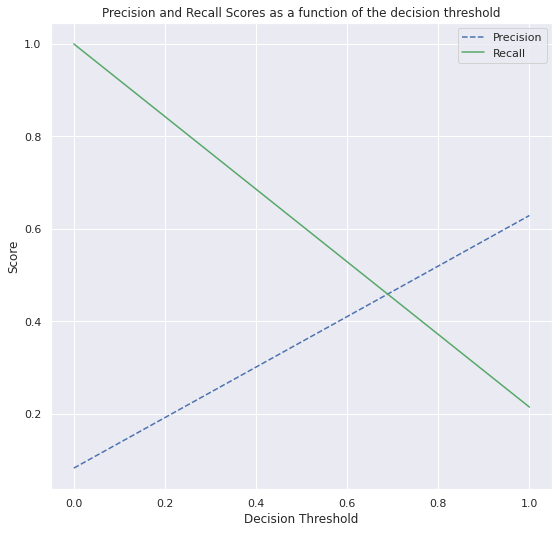

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold KNN.png')

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42, solver = 'liblinear')
logreg_model = logreg.fit(xtrain, ytrain)

In [ ]:
# Predict the test data
y_predicted = logreg.predict(xtest)
y_predicted

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
'''
The output of a Logistic regression model is a probability. 
We can select a threshold value. 
If the probability is greater than this threshold value, 
the event is predicted to happen otherwise it is predicted not to happen.

To get the probability of the label, repectively for class 0 and 1
'''

y_predicted_proba = logreg.predict_proba(xtest)
y_predicted_proba

array([[0.9865461 , 0.0134539 ],
       [0.99095139, 0.00904861],
       [0.96644298, 0.03355702],
       ...,
       [0.81144079, 0.18855921],
       [0.98833637, 0.01166363],
       [0.97319165, 0.02680835]])

In [ ]:
print('\nclassification report')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     10054
         1.0       0.86      0.24      0.38       908

    accuracy                           0.93     10962
   macro avg       0.90      0.62      0.67     10962
weighted avg       0.93      0.93      0.92     10962

LogReg: ROC AUC =  61.9 %
LogReg: Precision =  85.5 %
LogReg: Recall =  24.1 %
LogReg: Accuracy =  93.4 %
LogReg: F1-Score =  37.6 %


array([[10017,    37],
       [  689,   219]])

In [ ]:
#Save Machine Learning Model
import pickle
pickle.dump(logreg_model, open('Logreg.pkl', 'wb'))

In [ ]:
#Load and print model score
loaded_model = pickle.load(open('Logreg.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.9337712096332786


In [ ]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  93.14 %
test score :  93.38 %


ROC AUC Score:  61.9 %


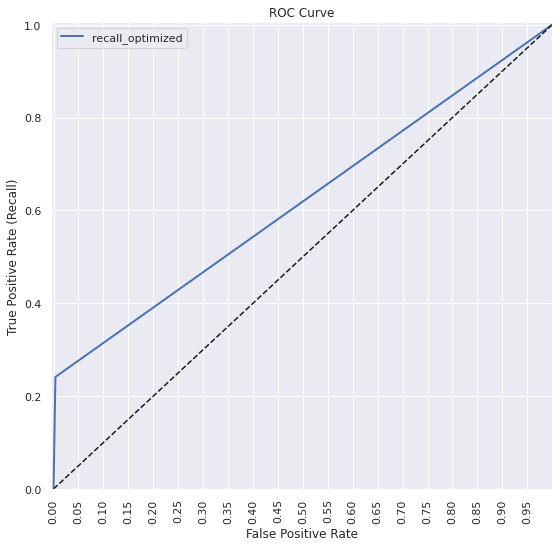

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_predicted)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/Logreg ROC Curve.png')

In [ ]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_predicted)

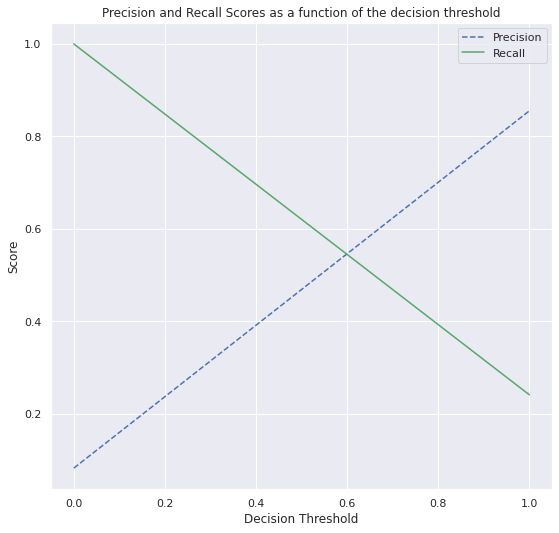

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold Logreg.png')

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt_model = dt.fit(xtrain,ytrain)
y_predicted = dt.predict(xtest)

In [ ]:
print('\nclassification report')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('Decision Tree: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('Decision Tree: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('Decision Tree: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('Decision Tree: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('Decision Tree: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94     10054
         1.0       0.39      0.44      0.42       908

    accuracy                           0.90     10962
   macro avg       0.67      0.69      0.68     10962
weighted avg       0.90      0.90      0.90     10962

Decision Tree: ROC AUC =  69.2 %
Decision Tree: Precision =  39.4 %
Decision Tree: Recall =  44.5 %
Decision Tree: Accuracy =  89.7 %
Decision Tree: F1-Score =  41.8 %


array([[9432,  622],
       [ 504,  404]])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# list of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion =['entropy']
splitter = ['random']

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'criterion':criterion,
               'splitter': splitter
                }

# Init Logres dengan Gridsearch, cross validation = 5
dt2 = DecisionTreeClassifier(random_state=42)
clf = RandomizedSearchCV(dt2, hyperparameters, cv=5, random_state=42)

#Fitting Model
dt_model = clf.fit(xtrain, ytrain)

#Prediksi menggunakan model baru
y_pred = dt_model.predict(xtest)#Check performa dari model
print('\nclassification report')
print(classification_report(ytest, y_pred)) # generate the precision, recall, f-1 score, num
print('Decision Tree: ROC AUC = ',str(round(roc_auc_score(ytest, y_pred)*100,1)), '%')
print('Decision Tree: Precision = ',str(round(precision_score(ytest, y_pred)*100,1)), '%')
print('Decision Tree: Recall = ',str(round(recall_score(ytest, y_pred)*100,1)), '%')
print('Decision Tree: Accuracy = ',str(round(accuracy_score(ytest, y_pred)*100,1)), '%')
print('Decision Tree: F1-Score = ',str(round(f1_score(ytest, y_pred)*100,1)), '%')
confusion_matrix(ytest, y_pred)


classification report
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     10054
         1.0       0.78      0.22      0.34       908

    accuracy                           0.93     10962
   macro avg       0.86      0.61      0.65     10962
weighted avg       0.92      0.93      0.91     10962

Decision Tree: ROC AUC =  60.6 %
Decision Tree: Precision =  78.0 %
Decision Tree: Recall =  21.8 %
Decision Tree: Accuracy =  93.0 %
Decision Tree: F1-Score =  34.1 %


array([[9998,   56],
       [ 710,  198]])

In [ ]:
#Save Machine Learning Model
import pickle
pickle.dump(dt_model, open('Decision Tree.pkl', 'wb'))

In [ ]:
#Load and print model score
loaded_model = pickle.load(open('Decision Tree.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.930122240467068


In [ ]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  93.2 %
test score :  93.01 %


ROC AUC Score:  60.6 %


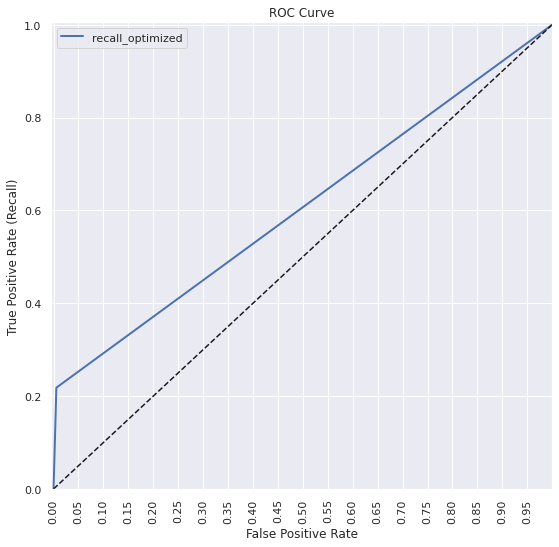

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#make roc auc curve
fpr, tpr, auc_thresholds = roc_curve(ytest, y_pred)
print('ROC AUC Score: ',str(round(auc(fpr, tpr)*100,1)), '%') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')
#plt.savefig('fig/Decision Tree ROC Curve.png')

In [ ]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(ytest, y_pred)

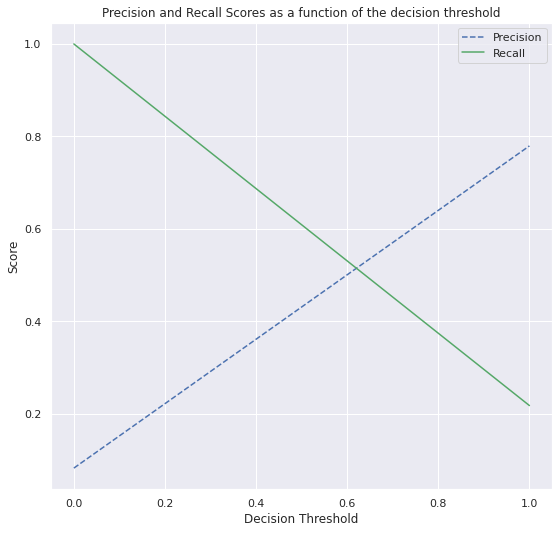

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig('fig/Precision-Recall Threshold DT.png')

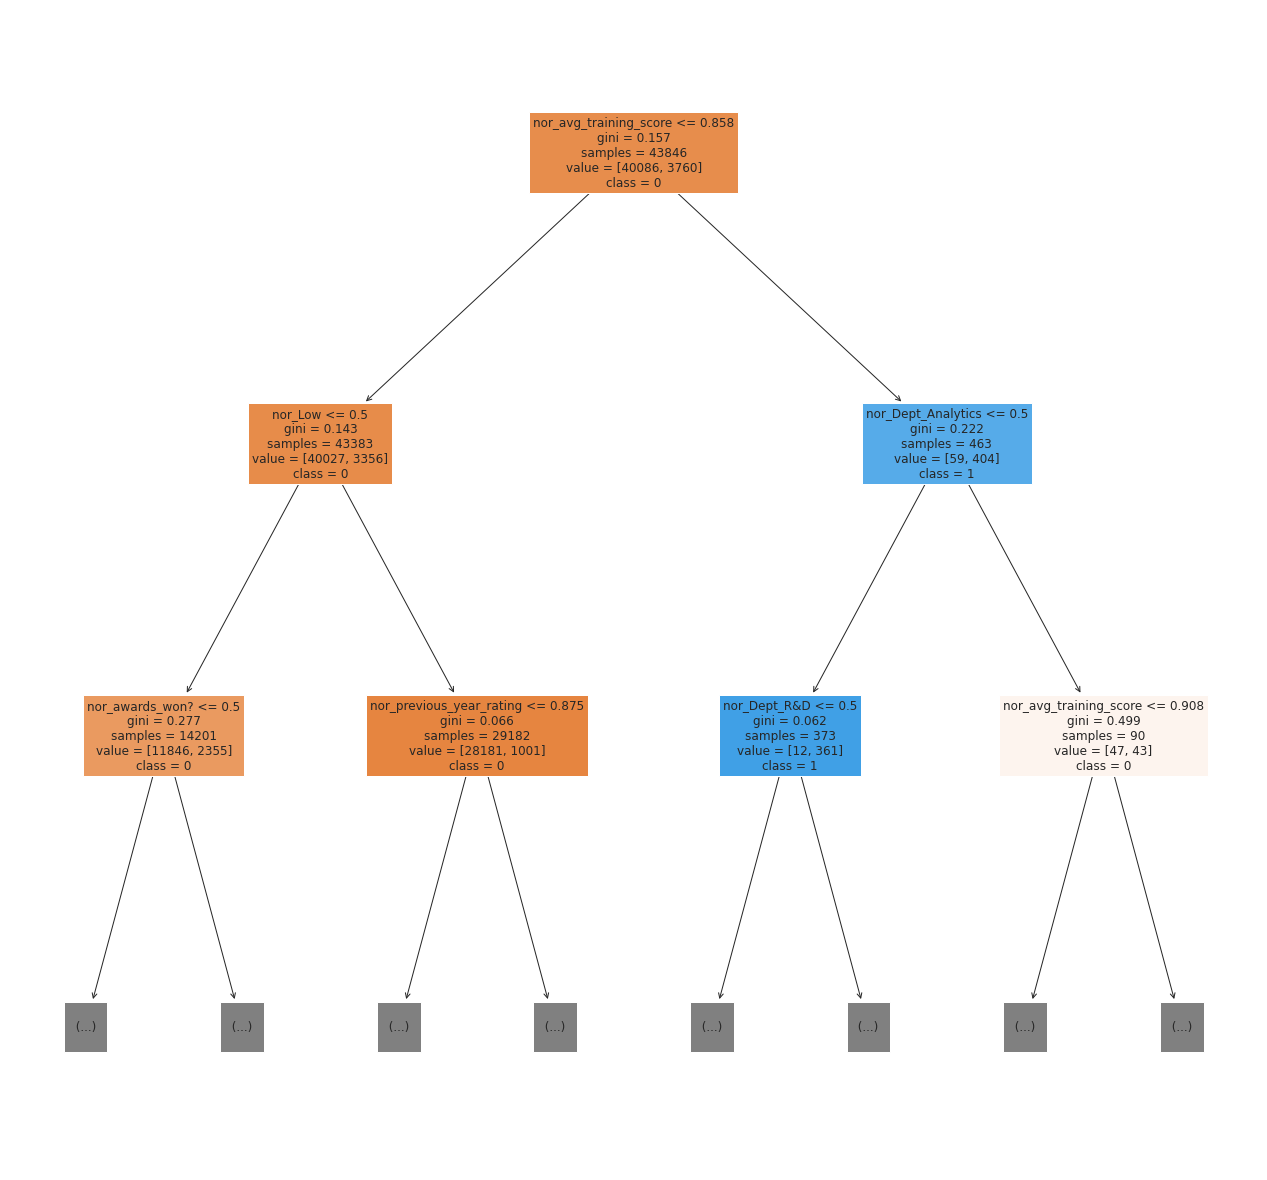

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(dt,
               feature_names = x_norm.columns.tolist(), 
               class_names=['0','1'],
               filled = True, max_depth=2, fontsize=12)
plt.show()

## XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

data_dmatrix = xgb.DMatrix(data=x_norm, label=y_norm)

xtrain, xtest, ytrain, ytest = train_test_split(x_norm,
                                                y_norm,
                                                test_size=0.2,
                                                shuffle = True,
                                                stratify = y_norm,
                                                random_state=42) #Splitting the data into Train and Test

xgb_classifier = xgb.XGBClassifier()
norm_model = xgb_classifier.fit(x_norm, y_norm)
y_predicted = norm_model.predict(xtest)
y_predicted_train = norm_model.predict(xtrain)

print("\nClassification Report")
print(classification_report(ytest, y_predicted))
print('XGBoost: ROC AUC = ', str(round(roc_auc_score(ytest, y_predicted)*100,1)),"%")
print('XGBoost: Precision = ', str(round(precision_score(ytest, y_predicted)*100,1)),"%")
print('XGBoost: Recall = ', str(round(recall_score(ytest, y_predicted)*100,1)),"%")
print('XGBoost: Accuracy = ', str(round(accuracy_score(ytest, y_predicted)*100,1)),"%")
print("XGBoost: F1 Score =  ", str(round(f1_score(ytest, y_predicted)*100,1)),"%")
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, y_predicted)



Classification Report
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     10028
         1.0       0.99      0.28      0.44       934

    accuracy                           0.94     10962
   macro avg       0.96      0.64      0.70     10962
weighted avg       0.94      0.94      0.92     10962

XGBoost: ROC AUC =  64.1 %
XGBoost: Precision =  98.5 %
XGBoost: Recall =  28.2 %
XGBoost: Accuracy =  93.8 %
XGBoost: F1 Score =   43.8 %


array([[10024,     4],
       [  671,   263]])

In [ ]:
print("\nTrain vs Test Accuration")
import pickle
pickle.dump(xgb_classifier, open('XGBoost_model.pkl', 'wb'))

loaded_model = pickle.load(open('XGBoost_model.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
#pred = loaded_model.predict(xtest)
#print(result)
#print(pred)

print('train accuracy : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test accuracy : ', str(round(loaded_model.score(xtest, ytest)*100,2)), '%')


Train vs Test Accuration
train accuracy :  93.94 %
test accuracy :  93.84 %


# Predictions

In [ ]:
data_test_ori = pd.read_csv("test_hr_for_promotion.csv")
data_test_ori.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [ ]:
data_test = data_test_ori.copy()
data_test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [ ]:
#see the amount of data in the dataset
print('there are ' + str(len(data_test)) + ' rows of data in the dataset')

there are 23490 rows of data in the dataset


In [ ]:
data_test.duplicated().sum()

0

In [ ]:
data_test.isnull().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [ ]:
data_test.drop(['employee_id'], axis=1, inplace=True)

data_test['education'] = data_test['education'].fillna(data_test['education'].mode()[0])

data_test['previous_year_rating'].fillna(data_test['previous_year_rating'].median(), inplace=True)

#data_test = data_test.drop_duplicates()

data_test['potential_region'] = np.where(data_test['region'].isin(['region_4','region_17','region_25','region_28','region_23',
                                                   'region_3','region_7']),
                              1, 0)

data_test['performance_level'] = np.where(
    (
        (data_test['previous_year_rating'] == 5) &
        (data_test['KPIs_met >80%'] == 1) &
        (data_test['awards_won?'] == 1)
    ),
"Best",
    np.where((
        ((data_test['previous_year_rating'] == 4) & (data_test['KPIs_met >80%'] == 0) & (data_test['awards_won?'] == 1)) | 
        ((data_test['previous_year_rating'] == 4) & (data_test['KPIs_met >80%'] == 1) & (data_test['awards_won?'] == 0)) |
        ((data_test['previous_year_rating'] == 4) & (data_test['KPIs_met >80%'] == 1) & (data_test['awards_won?'] == 1)) |
        ((data_test['previous_year_rating'] == 5) & (data_test['KPIs_met >80%'] == 0) & (data_test['awards_won?'] == 1)) |
        ((data_test['previous_year_rating'] == 5) & (data_test['KPIs_met >80%'] == 1) & (data_test['awards_won?'] == 0))
    ),
    "Better",
    np.where(
        ((data_test['previous_year_rating'] == 3) & (data_test['KPIs_met >80%'] == 0) & (data_test['awards_won?'] == 1)) | 
        ((data_test['previous_year_rating'] == 3) & (data_test['KPIs_met >80%'] == 1) & (data_test['awards_won?'] == 0)) |
        ((data_test['previous_year_rating'] == 3) & (data_test['KPIs_met >80%'] == 1) & (data_test['awards_won?'] == 1)),
        "Good","Low"
    )
    )
)

data_test['High_Avg_Tscore'] = np.where(data_test['avg_training_score']>=90, 1, 0)

data_test['male'] = np.where(data_test['gender']=='m', 1, 0)

#merubah fitur department dari data categorical menjadi numerik menggunakan metode one hot encoding
dummies_dept = pd.get_dummies(data_test['department'], prefix='Dept')
data_test = pd.concat([data_test, dummies_dept], axis=1)

#merubah fitur education dari data categorical menjadi numerik menggunakan metode one hot encoding
dummies_edu = pd.get_dummies(data_test['education'])
data_test = pd.concat([data_test, dummies_edu], axis=1)

#merubah fitur recruitment_channel dari data categorical menjadi numerik menggunakan metode one hot encoding
dummies_rc = pd.get_dummies(data_test['recruitment_channel'])
data_test = pd.concat([data_test, dummies_rc], axis=1)

#merubah fitur performance_level dari data categorical menjadi numerik menggunakan metode one hot encoding
dummies_pl = pd.get_dummies(data_test['performance_level'])
data_test = pd.concat([data_test, dummies_pl], axis=1)

features = ['no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?',
        'avg_training_score','potential_region','Dept_Analytics','Dept_Finance','Dept_HR','Dept_Legal',
           'Dept_Operations','Dept_Procurement','Dept_R&D','Dept_Sales & Marketing','Dept_Technology',"Bachelor's",
           'Below Secondary',"Master's & above", 'other','referred','sourcing','male','High_Avg_Tscore','Best','Better','Good','Low']

for var in features:
    data_test['log_'+var]= (data_test[var]+1).apply(np.log)
    
for var in features:
    data_test['nor_'+var] = MinMaxScaler().fit_transform(data_test[var].values.reshape(len(data_test),1))

data_test.drop(['department', 'region', 'education', 'gender', 'recruitment_channel', 'performance_level',
               'referred', 'log_Better', 'log_Best', "Bachelor's", 'High_Avg_Tscore', 'sourcing', "KPIs_met >80%",
                'log_referred', 'Best', 'Dept_Operations', 'Dept_HR', 'log_length_of_service', 'Dept_Technology', 'log_male',
                'Dept_R&D', 'log_potential_region', 'potential_region', "Master's & above", "awards_won?", "log_previous_year_rating",
                "male", "log_Dept_Analytics", 'log_Dept_Finance', "log_Dept_Operations", 'other', 'log_Below Secondary', "age", 
                "log_KPIs_met >80%", 'log_Dept_Sales & Marketing', "Dept_Sales & Marketing", 'log_sourcing', 'log_no_of_trainings', 
                "log_Master's & above", "no_of_trainings", "log_Dept_R&D", "log_Dept_HR", 'Low', "Dept_Legal", 'log_age', 
                "Dept_Finance", "previous_year_rating", "log_other", "log_Bachelor's", "avg_training_score", "log_Low", "Dept_Analytics", 
                "log_Dept_Technology", "log_awards_won?", "log_avg_training_score", "Dept_Procurement", "log_Good", "log_Dept_Procurement", 
                "length_of_service", "log_Dept_Legal", "Better", "log_High_Avg_Tscore", "Good", "Below Secondary"
               ],
              axis = 1, inplace=True)
    
data_test.head()

,nor_no_of_trainings,nor_age,nor_previous_year_rating,nor_length_of_service,nor_KPIs_met >80%,nor_awards_won?,nor_avg_training_score,nor_potential_region,nor_Dept_Analytics,nor_Dept_Finance,...,nor_Master's & above,nor_other,nor_referred,nor_sourcing,nor_male,nor_High_Avg_Tscore,nor_Best,nor_Better,nor_Good,nor_Low
0,0.00,0.100,0.50,0.000000,1.0,0.0,0.633333,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.00,0.275,0.50,0.121212,0.0,0.0,0.200000,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.00,0.275,0.00,0.090909,0.0,0.0,0.133333,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.25,0.275,0.25,0.242424,0.0,0.0,0.433333,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.00,0.250,0.75,0.181818,0.0,0.0,0.366667,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


## Predict with `xgb_classifier` fom XGBoost

In [ ]:
y_test = xgb_classifier.predict(data_test)
y_test_prob = xgb_classifier.predict_proba(data_test)
results = pd.DataFrame(data = {
    "id": data_test_ori['employee_id'],
    "Promoted": y_test,
    "Probability": y_test_prob[:,1]
})
print(results.head())
print("The number of Promoted Employee is: " + str(len(results[results["Promoted"] == 1])))

      id  Promoted  Probability
0   8724       0.0     0.152758
1  74430       0.0     0.002881
2  72255       0.0     0.001283
3  38562       0.0     0.016515
4  64486       0.0     0.012102
The number of Promoted Employee is: 558


In [ ]:
print('The percentage of employees who get promoted is', str(round((2040/23490)*100,2)), '%')
print('The number of employees who get promoted using XGBoost model are', str(len(results[results["Promoted"] == 1])), 'out of', str(len(data_test)), 'employees')

The percentage of employees who get promoted is 8.68 %
The number of employees who get promoted using XGBoost model are 558 out of 23490 employees
